# Telecom Churn Prediction 

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

### Import Required Libraries

In [1226]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

import missingno as msno

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

import time


# Set environment settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [1352]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error,confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, roc_auc_score

## Step 1: Read the Data from .csv file

In [1228]:
# read data
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

In [1229]:
# check the shape
print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [1475]:
# View the data dictionary
data_dict

Acronyms  \
0     CIRCLE_ID   
1           LOC   
2           STD   
3            IC   
4            OG   
5           T2T   
6       T2M       
7       T2O       
8       T2F       
9       T2C       
10     ARPU       
11      MOU       
12      AON       
13     ONNET      
14   OFFNET       
15         ROAM   
16       SPL      
17      ISD       
18     RECH       
19      NUM       
20      AMT       
21      MAX       
22     DATA       
23       3G       
24       AV       
25      VOL       
26       2G       
27      PCK       
28    NIGHT       
29  MONTHLY       
30    SACHET      
31      *.6       
32      *.7       
33      *.8       
34      FB_USER   
35      VBC       

                                                                          Description  
0                                Telecom circle area to which the customer belongs to  
1                                             Local calls  within same telecom circle  
2                                               STD calls  outside the calling circle  
3                                                                      Incoming calls  
4                                                                      Outgoing calls  
5                            Operator T to T ie within same operator mobile to mobile  
6                                                 Operator T to other operator mobile  
7                                             Operator T to other operator fixed line  
8                                                      Operator T to fixed lines of T  
9                                                   Operator T to its own call center  
10                                                           Average revenue per user  
11                                                      Minutes of usage  voice calls  
12        Age on network  number of days the customer is using the operator T network  
13                                 All kind of calls within the same operator network  
14                                   All kind of calls outside the operator T network  
15                         Indicates that customer is in roaming zone during the call  
16                                                                      Special calls  
17                                                                          ISD calls  
18                                                                           Recharge  
19                                                                             Number  
20                                                           Amount in local currency  
21                                                                            Maximum  
22                                                                    Mobile internet  
23                                                                          G network  
24                                                                            Average  
25                                                 Mobile internet usage volume in MB  
26                                                                          G network  
27                                              Prepaid service schemes called  PACKS  
28                                     Scheme to use during specific night hours only  
29                                Service schemes with validity equivalent to a month  
30                                 Service schemes with validity smaller than a month  
31                                                          KPI for the month of June  
32                                                          KPI for the month of July  
33                                                        KPI for the month of August  
34   Service scheme to avail services of Facebook and similar social networking sites  
35  Volume based cost  when no specific scheme is not purchased and paid as per usage

In [1231]:
# check sample data
data.head(5)

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [1232]:
# Check the Churn Probabiltiy in Train dataset
data['churn_probability'].value_counts()

0    62867
1     7132
Name: churn_probability, dtype: int64

In [1233]:
data['churn_probability'].value_counts(normalize=True)

0    0.898113
1    0.101887
Name: churn_probability, dtype: float64

In [1234]:
# Check Summary of datatypes
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [1235]:
data.dtypes.value_counts()

float64    135
int64       28
object       9
dtype: int64

### Observation: 
- There are total 172 columns and 69999 rows in test data
- Most of the columns are numeric (163) and only 9 are object type

In [1236]:
# check data stats
data.describe(include='all').transpose()

count unique        top   freq         mean  \
id                        69999.0    NaN        NaN    NaN      34999.0   
circle_id                 69999.0    NaN        NaN    NaN        109.0   
loc_og_t2o_mou            69297.0    NaN        NaN    NaN          0.0   
std_og_t2o_mou            69297.0    NaN        NaN    NaN          0.0   
loc_ic_t2o_mou            69297.0    NaN        NaN    NaN          0.0   
last_date_of_month_6        69999      1  6/30/2014  69999          NaN   
last_date_of_month_7        69600      1  7/31/2014  69600          NaN   
last_date_of_month_8        69266      1  8/31/2014  69266          NaN   
arpu_6                    69999.0    NaN        NaN    NaN   283.134365   
arpu_7                    69999.0    NaN        NaN    NaN   278.185912   
arpu_8                    69999.0    NaN        NaN    NaN   278.858826   
onnet_mou_6               67231.0    NaN        NaN    NaN   133.153275   
onnet_mou_7               67312.0    NaN        NaN    NaN   133.894438   
onnet_mou_8               66296.0    NaN        NaN    NaN   132.978257   
offnet_mou_6              67231.0    NaN        NaN    NaN   198.874771   
offnet_mou_7              67312.0    NaN        NaN    NaN   197.153383   
offnet_mou_8              66296.0    NaN        NaN    NaN   196.543577   
roam_ic_mou_6             67231.0    NaN        NaN    NaN     9.765435   
roam_ic_mou_7             67312.0    NaN        NaN    NaN     7.014568   
roam_ic_mou_8             66296.0    NaN        NaN    NaN     7.004892   
roam_og_mou_6             67231.0    NaN        NaN    NaN    14.186457   
roam_og_mou_7             67312.0    NaN        NaN    NaN     9.842191   
roam_og_mou_8             66296.0    NaN        NaN    NaN     9.771783   
loc_og_t2t_mou_6          67231.0    NaN        NaN    NaN    46.904854   
loc_og_t2t_mou_7          67312.0    NaN        NaN    NaN    46.166503   
loc_og_t2t_mou_8          66296.0    NaN        NaN    NaN    45.686109   
loc_og_t2m_mou_6          67231.0    NaN        NaN    NaN    93.238231   
loc_og_t2m_mou_7          67312.0    NaN        NaN    NaN     90.79924   
loc_og_t2m_mou_8          66296.0    NaN        NaN    NaN    91.121447   
loc_og_t2f_mou_6          67231.0    NaN        NaN    NaN     3.743179   
loc_og_t2f_mou_7          67312.0    NaN        NaN    NaN     3.777031   
loc_og_t2f_mou_8          66296.0    NaN        NaN    NaN     3.661652   
loc_og_t2c_mou_6          67231.0    NaN        NaN    NaN     1.126025   
loc_og_t2c_mou_7          67312.0    NaN        NaN    NaN     1.361052   
loc_og_t2c_mou_8          66296.0    NaN        NaN    NaN      1.42084   
loc_og_mou_6              67231.0    NaN        NaN    NaN   143.893585   
loc_og_mou_7              67312.0    NaN        NaN    NaN    140.75012   
loc_og_mou_8              66296.0    NaN        NaN    NaN   140.476486   
std_og_t2t_mou_6          67231.0    NaN        NaN    NaN    80.619382   
std_og_t2t_mou_7          67312.0    NaN        NaN    NaN    83.775851   
std_og_t2t_mou_8          66296.0    NaN        NaN    NaN    83.471486   
std_og_t2m_mou_6          67231.0    NaN        NaN    NaN     88.15211   
std_og_t2m_mou_7          67312.0    NaN        NaN    NaN    91.538615   
std_og_t2m_mou_8          66296.0    NaN        NaN    NaN    90.586999   
std_og_t2f_mou_6          67231.0    NaN        NaN    NaN     1.126377   
std_og_t2f_mou_7          67312.0    NaN        NaN    NaN     1.084062   
std_og_t2f_mou_8          66296.0    NaN        NaN    NaN     1.057739   
std_og_t2c_mou_6          67231.0    NaN        NaN    NaN          0.0   
std_og_t2c_mou_7          67312.0    NaN        NaN    NaN          0.0   
std_og_t2c_mou_8          66296.0    NaN        NaN    NaN          0.0   
std_og_mou_6              67231.0    NaN        NaN    NaN   169.900601   
std_og_mou_7              67312.0    NaN        NaN    NaN   176.401217   
std_og_mou_8              66296.0    NaN        NaN  

In [1237]:
# store the columns name based on datatypes

id_cols = ['circle_id']
print(id_cols,"\n")
date_cols = data.select_dtypes(include='datetime64').columns
print(len(date_cols),date_cols,"\n")

cat_cols = data.select_dtypes(include='object').columns
print(len(date_cols),cat_cols,"\n")

number_cols = data.select_dtypes(include=['int64', 'float64']).columns.difference(id_cols)
print(len(number_cols) ,number_cols,"\n")

['circle_id'] 

0 Index([], dtype='object') 

0 Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object') 

162 Index(['aon', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'arpu_6', 'arpu_7', 'arpu_8',
       ...
       'total_rech_data_8', 'total_rech_num_6', 'total_rech_num_7',
       'total_rech_num_8', 'vol_2g_mb_6', 'vol_2g_mb_7', 'vol_2g_mb_8',
       'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8'],
      dtype='object', length=162) 



In [1238]:
# checking sample categorical values
data[cat_cols].head(5)

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0           6/22/2014           7/10/2014           8/24/2014   
1           6/12/2014           7/10/2014           8/26/2014   
2           6/11/2014           7/22/2014           8/24/2014   
3           6/15/2014           7/21/2014           8/25/2014   
4           6/25/2014           7/26/2014           8/30/2014   

  date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  
0                      NaN                      NaN                      NaN  
1                      NaN                 7/8/2014                      NaN  
2                      NaN                      NaN                      NaN  
3                      NaN                      NaN                      NaN  
4                6/25/2014                7/23/2014                8/20/2014

In [1239]:
# covert the columns in cat_cols to datatime as they contains date
data[cat_cols] = data[cat_cols].apply(pd.to_datetime)

In [1240]:
#check sample 
data[cat_cols].head(5)

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0           2014-06-30           2014-07-31           2014-08-31   
1           2014-06-30           2014-07-31           2014-08-31   
2           2014-06-30           2014-07-31           2014-08-31   
3           2014-06-30           2014-07-31           2014-08-31   
4           2014-06-30           2014-07-31           2014-08-31   

  date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
0          2014-06-22          2014-07-10          2014-08-24   
1          2014-06-12          2014-07-10          2014-08-26   
2          2014-06-11          2014-07-22          2014-08-24   
3          2014-06-15          2014-07-21          2014-08-25   
4          2014-06-25          2014-07-26          2014-08-30   

  date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  
0                      NaT                      NaT                      NaT  
1                      NaT               2014-07-08                      NaT  
2                      NaT                      NaT                      NaT  
3                      NaT                      NaT                      NaT  
4               2014-06-25               2014-07-23               2014-08-20

In [1241]:
# Reassign the columns list to datetime
date_cols = data.select_dtypes(include='datetime64').columns
print(date_cols)

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')


### Step 2: Data Cleaning and Preparation

#### Check and handle missing values

In [1242]:
# Check the Columns with Single Unique Value Counts
cols_with_single_value = []
for col in data.columns:
    if data[col].nunique() == 1:
        cols_with_single_value.append(col)

print(cols_with_single_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [1243]:
# Inspecting single value columns
for col in cols_with_single_value:
    print(col)
    print(data[col].value_counts(dropna=False))
    print("********************************")

circle_id
109    69999
Name: circle_id, dtype: int64
********************************
loc_og_t2o_mou
0.0    69297
NaN      702
Name: loc_og_t2o_mou, dtype: int64
********************************
std_og_t2o_mou
0.0    69297
NaN      702
Name: std_og_t2o_mou, dtype: int64
********************************
loc_ic_t2o_mou
0.0    69297
NaN      702
Name: loc_ic_t2o_mou, dtype: int64
********************************
last_date_of_month_6
2014-06-30    69999
Name: last_date_of_month_6, dtype: int64
********************************
last_date_of_month_7
2014-07-31    69600
NaT             399
Name: last_date_of_month_7, dtype: int64
********************************
last_date_of_month_8
2014-08-31    69266
NaT             733
Name: last_date_of_month_8, dtype: int64
********************************
std_og_t2c_mou_6
0.0    67231
NaN     2768
Name: std_og_t2c_mou_6, dtype: int64
********************************
std_og_t2c_mou_7
0.0    67312
NaN     2687
Name: std_og_t2c_mou_7, dtype: int64
*********

In [1244]:
# based on Analysis drop those columns 
data.drop(cols_with_single_value, axis=1, inplace=True)

In [1245]:
# Generating a list of column names based on their corresponding types

date_cols = ['date_of_last_rech_6',
            'date_of_last_rech_7',
            'date_of_last_rech_8',
            'date_of_last_rech_data_6',
            'date_of_last_rech_data_7',
            'date_of_last_rech_data_8',
            ]

cat_cols = ['night_pck_user_6',
            'night_pck_user_7',
            'night_pck_user_8',
            'fb_user_6',
            'fb_user_7',
            'fb_user_8',
           ]

numerical_cols = [col for col in data.columns if col not in date_cols + cat_cols]

In [1246]:
#drop the date columns as we already have data at month level 
data.drop(columns=date_cols, axis=1, inplace=True)

In [1247]:
missing_value_ratio = round(100*(data.isna().sum(axis=0)/data.shape[0]), 2)
missing_value_ratio[missing_value_ratio > 70].sort_values(ascending=False)

total_rech_data_6     74.90
arpu_3g_6             74.90
max_rech_data_6       74.90
fb_user_6             74.90
count_rech_2g_6       74.90
night_pck_user_6      74.90
count_rech_3g_6       74.90
arpu_2g_6             74.90
av_rech_amt_data_6    74.90
fb_user_7             74.48
night_pck_user_7      74.48
arpu_2g_7             74.48
arpu_3g_7             74.48
av_rech_amt_data_7    74.48
total_rech_data_7     74.48
count_rech_3g_7       74.48
count_rech_2g_7       74.48
max_rech_data_7       74.48
av_rech_amt_data_8    73.69
count_rech_3g_8       73.69
arpu_3g_8             73.69
count_rech_2g_8       73.69
arpu_2g_8             73.69
max_rech_data_8       73.69
night_pck_user_8      73.69
total_rech_data_8     73.69
fb_user_8             73.69
dtype: float64

<AxesSubplot:>

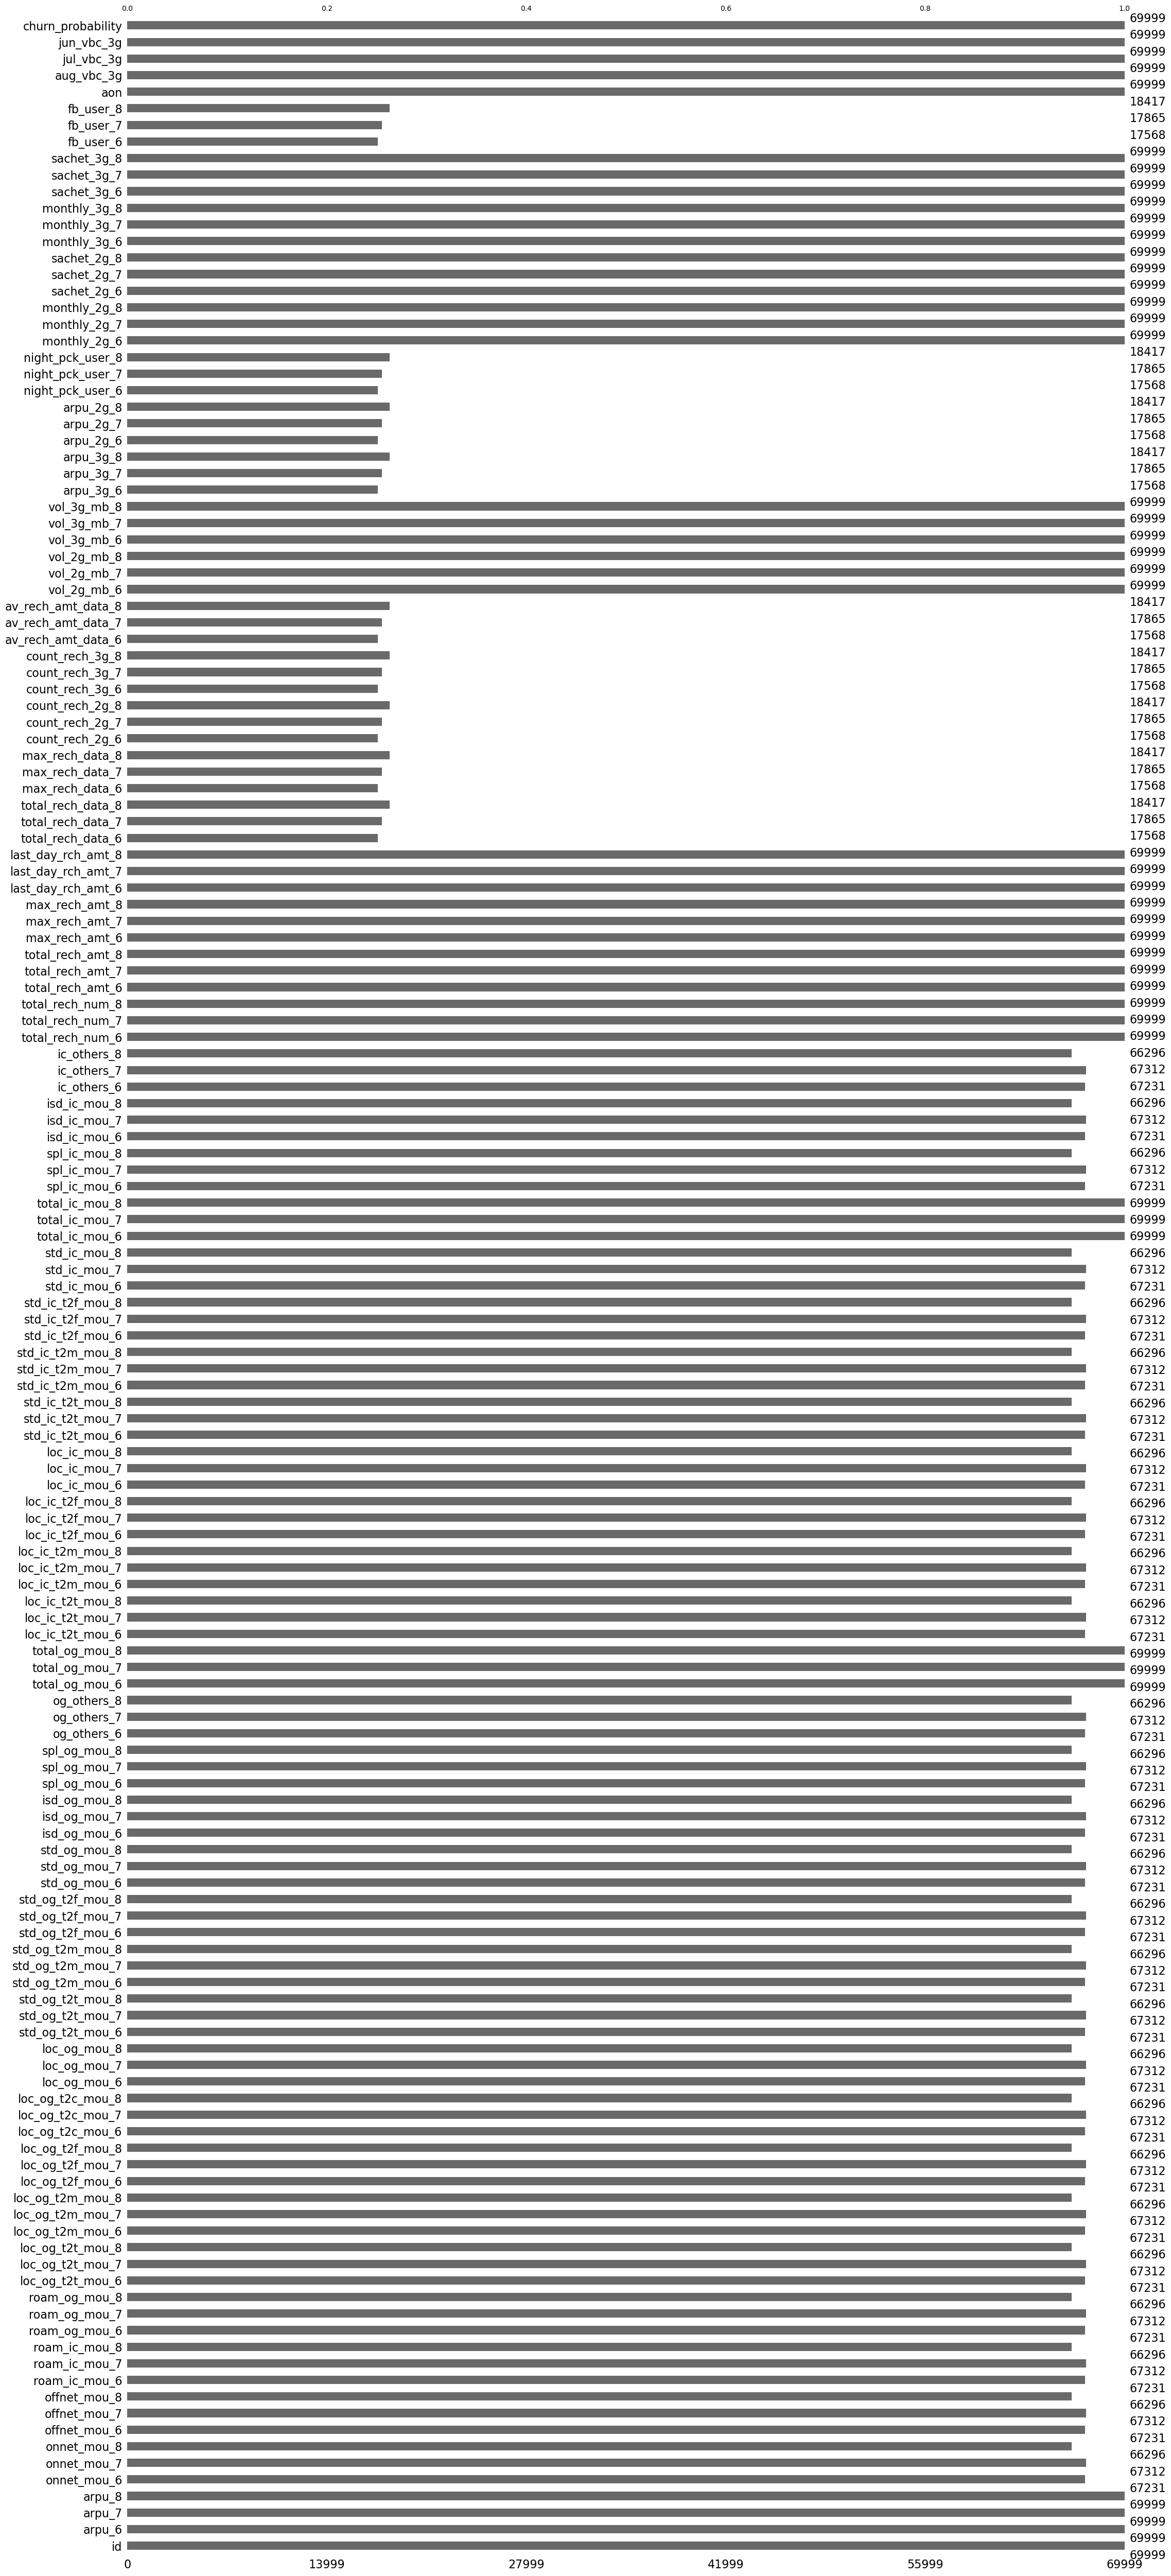

In [1248]:
# Use Visualization to understand the missing values
msno.bar(data)

In [1249]:
# Lets Group similar columns together
# Columns with recharge information 
recharge_cols = data.columns[data.columns.str.contains('_rech_')]
print(recharge_cols)

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object')


In [1250]:
# Replacing NaN values in recharge related columns with 0 in the training set
data[recharge_cols] = data[recharge_cols].fillna(0)
print(data[recharge_cols].isnull().sum()*100/data.shape[1])

total_rech_num_6      0.0
total_rech_num_7      0.0
total_rech_num_8      0.0
total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
count_rech_2g_6       0.0
count_rech_2g_7       0.0
count_rech_2g_8       0.0
count_rech_3g_6       0.0
count_rech_3g_7       0.0
count_rech_3g_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [1251]:
# Columns with 'arpu' information 
arpu_cols = data.columns[data.columns.str.contains('arpu_')]
print(arpu_cols)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [1252]:
# Replacing NaN values in ARPU related columns with 0 in the training set
data[arpu_cols] = data[arpu_cols].fillna(0)
print(data[arpu_cols].isnull().sum()*100/data.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [1253]:
# Inspecting categorical columns
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


In [1254]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We'll need to convert them to the `category` data type from float64
data[cat_cols] = data[cat_cols].fillna(-1).astype('category')
print(data[cat_cols].isnull().sum()*100/data.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [1255]:
# Verifying the change in dtype on the train set
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.0 KB


In [1256]:
# Checking for the columns which have missing values present
missing_value_ratio[(missing_value_ratio > 0) & (missing_value_ratio <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
og_others_8         5.29
std_og_t2m_mou_8    5.29
loc_ic_t2t_mou_8    5.29
std_og_t2t_mou_8    5.29
loc_ic_t2m_mou_8    5.29
loc_og_mou_8        5.29
loc_ic_t2f_mou_8    5.29
loc_og_t2c_mou_8    5.29
loc_ic_mou_8        5.29
isd_og_mou_8        5.29
std_ic_t2t_mou_8    5.29
loc_og_t2f_mou_8    5.29
std_ic_t2m_mou_8    5.29
spl_ic_mou_8        5.29
onnet_mou_8         5.29
loc_og_t2t_mou_8    5.29
std_ic_t2f_mou_8    5.29
isd_ic_mou_8        5.29
roam_og_mou_8       5.29
std_ic_mou_8        5.29
offnet_mou_8        5.29
roam_ic_mou_8       5.29
ic_others_6         3.95
og_others_6         3.95
loc_ic_t2t_mou_6    3.95
isd_ic_mou_6        3.95
spl_ic_mou_6        3.95
loc_ic_t2m_mou_6    3.95
std_ic_t2m_mou_6    3.95
loc_ic_t2f_mou_6    3.95
loc_ic_mou_6        3.95
std_ic_mou_6        3.95
std_ic_t2t_mou_6    3.95
std_ic_t2f_mou_6    3.95
spl_og_mou_6        3.95


In [1257]:
# Creating a list containing these columns to be processed later for imputation using the KNN technique.
missing_values_list = missing_value_ratio[(missing_value_ratio > 0) & (missing_value_ratio <= 70)].index
print(missing_values_list)

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

### Deriving New Features
- Objective is to derive the high value customer
    - Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount
    - Total Amount = Total Data Recharge Amount + Total Recharge Amount
    - Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2

In [1258]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the training set
data['total_rech_data_amt_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_rech_data_amt_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['total_amt_6'] = data['total_rech_data_amt_6'] + data['total_rech_amt_6']
data['total_amt_7'] = data['total_rech_data_amt_7'] + data['total_rech_amt_7']

data['total_avg_amt_6_7'] = data[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [1259]:
# Dropping the columns as they are not so useful columns for high value customer or churn
drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'av_rech_amt_data_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',]

data.drop(drop_data_cols, axis=1, inplace=True)

In [1260]:
# Checking for any null value in the derived column in the training set
data['total_avg_amt_6_7'].isnull().sum()

0

In [1261]:
data.shape

(69999, 150)

In [1262]:
# Finding cutoff value for only top 70% of high value customers
cutoff = data['total_avg_amt_6_7'].quantile(0.7)
cutoff

477.5

In [1263]:
# Filter high value customers in the new dataframe 
high_val_data = data[(data['total_avg_amt_6_7'] > cutoff)].copy()
high_val_data.shape

(20998, 150)

In [1264]:
# Check our Target Variable data type
high_val_data['churn_probability'].dtype

dtype('int64')

In [1265]:
high_val_data['churn_probability'] = high_val_data['churn_probability'].astype('category')

In [1266]:
# Check the value counts of churn and not-churn
print(high_val_data['churn_probability'].value_counts())

print("\n")

# Calculate churn ratio
print('Churn ratio:')
print(high_val_data['churn_probability'].value_counts(normalize=True))

0    19263
1     1735
Name: churn_probability, dtype: int64


Churn ratio:
0    0.917373
1    0.082627
Name: churn_probability, dtype: float64


#### Observation:
- only 8% has Churned and 92% are none churn

In [1267]:
# Create a copy of high_val_data  and use the new df (churn_data) for training set
churn_data = high_val_data.copy()
churn_data.reset_index(inplace=True)
churn_data.drop(['index'], axis=1, inplace=True)
churn_data.drop(columns = ['id'],inplace = True)
churn_data.shape

(20998, 149)

In [1268]:
# Get the list of columns with missing values in the training set
missing_val = round(100*(churn_data.isnull().sum(axis=0)/churn_data.shape[0]), 2)
s = missing_val.loc[missing_val>0]
impute_cols_num = list(s.index)
len(impute_cols_num)

81

In [1269]:
# Lets try to verify how many values are missing from the dataframe
drop = high_val_data.dropna()
print(churn_data.shape[0] - drop.shape[0])

1061


#### Imputing Values using MICE

In [1270]:
# Create imputer instance
imputer = KNNImputer(n_neighbors=5)

In [1271]:
# Separate df having columns to be imputed
df_num = churn_data[impute_cols_num]
churn_df = churn_data.drop(impute_cols_num, axis=1)

In [1272]:
%%time
# Impute using KNN imputer instance
df_imp = imputer.fit_transform(df_num)

CPU times: user 19.5 s, sys: 4.39 s, total: 23.9 s
Wall time: 21.8 s


In [1273]:
# Convert it to df post imputation
df_imp = pd.DataFrame(df_imp, columns=impute_cols_num)
df_imp.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [1274]:
# Merge the two dataframes together post imputation to create the final training set
final_df = pd.concat([df_imp, churn_df], join='inner', axis=1)
final_df.head()

onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
0        21.28         4.83         6.13         56.99         38.11   
1        10.43        24.99       194.43        317.11        341.79   
2       859.53       372.71         0.89        293.46        450.11   
3        93.18        38.29        29.86        531.19        507.76   
4         8.58        11.48        12.68        133.16        158.73   

   offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  \
0          9.63          53.64            0.0            0.0          15.73   
1        197.09           0.00            0.0            0.0           0.00   
2        386.91           0.00            0.0            0.0           0.00   
3        222.03           0.00            0.0            0.0           0.00   
4        182.83           0.00            0.0            0.0           0.00   

   roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
0            0.0            0.0             10.16              4.83   
1            0.0            0.0             10.43             24.99   
2            0.0            0.0            859.53            372.71   
3            0.0            0.0             93.18             38.29   
4            0.0            0.0              8.58             11.48   

   loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  \
0              6.13             36.74             19.88              4.61   
1            194.43            313.76            330.88            185.88   
2              0.89             79.79            424.63            378.01   
3             29.86            159.29            219.44             99.86   
4             12.68             96.91            149.44            157.23   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2c_mou_6  \
0             11.99              1.23              5.01               0.0   
1              3.26             10.91              4.94               0.0   
2             11.58             25.43              8.88               0.0   
3              0.00              0.00              0.00               0.0   
4             33.71              9.28             25.59               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  loc_og_mou_7  \
0              9.85              0.00         58.91         25.94   
1              0.00              0.00        327.46        366.79   
2              0.00              0.00        950.91        822.78   
3              0.00              0.36        252.48        257.74   
4              0.00              0.00        139.21        170.21   

   loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  std_og_t2t_mou_8  \
0         15.76               0.0               0.0               0.0   
1        385.26               0.0               0.0               0.0   
2        387.79               0.0               0.0               0.0   
3        129.73               0.0               0.0               0.0   
4        195.51               0.0               0.0               0.0   

   std_og_t2m_mou_6  std_og_t2m_mou_7  std_og_t2m_mou_8  std_og_t2f_mou_6  \
0              4.35              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2            202.08              0.00              0.00               0.0   
3            371.89            288.31            121.79               0.0   
4              2.53              0.00              0.00               0.0   

   std_og_t2f_mou_7  std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  \
0               0.0              0.00          4.35          0.00   
1               0.0              6.26          0.00          0.00   
2               0.0              0.00        202.08          0.00   
3               0.0              0.00        371.89        288.31   
4               0.0              0.00          2.53          0.00   

   std_og_

In [1275]:
final_df.shape

(20998, 149)

In [1276]:
final_df.isnull().sum().sort_values(ascending=False)

onnet_mou_6           0
total_rech_amt_7      0
max_rech_amt_6        0
max_rech_amt_7        0
max_rech_amt_8        0
last_day_rch_amt_6    0
last_day_rch_amt_7    0
last_day_rch_amt_8    0
max_rech_data_6       0
max_rech_data_7       0
max_rech_data_8       0
count_rech_2g_6       0
count_rech_2g_7       0
count_rech_2g_8       0
count_rech_3g_6       0
count_rech_3g_7       0
count_rech_3g_8       0
total_rech_amt_8      0
total_rech_amt_6      0
isd_ic_mou_6          0
total_rech_num_8      0
isd_ic_mou_8          0
ic_others_6           0
ic_others_7           0
ic_others_8           0
arpu_6                0
arpu_7                0
arpu_8                0
total_og_mou_6        0
total_og_mou_7        0
total_og_mou_8        0
total_ic_mou_6        0
total_ic_mou_7        0
total_ic_mou_8        0
total_rech_num_6      0
total_rech_num_7      0
vol_2g_mb_6           0
vol_2g_mb_7           0
vol_2g_mb_8           0
vol_3g_mb_6           0
monthly_3g_7          0
monthly_3g_8    

### Define Reusable Functions

In [1277]:
def calculate_classification_metrics(y_true, y_pred):
    """
    Calculate various classification metrics.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    pd.DataFrame: A DataFrame containing the calculated metrics.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [1519]:
def draw_roc(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)
    
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [1303]:
def plot_bar_graph(title, month, y_list, data):

    # Define custom color palettes with two mild colors
    custom_palette = ["#6baed6", "#fd8d3c"]

    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data, palette=custom_palette)
    
    plt.tight_layout()
    plt.show()

In [1302]:
def outlier_handling(dataframe):
 
    transformed_values = []
    for value in dataframe:
        if value <= 0:
            transformed_values.append(float(0))
        elif float(value) == float(1.0):
            transformed_values.append(float(1.5))
        else:
            transformed_values.append(float(np.log1p(value)))

    return transformed_values

### EDA

In [1516]:
# Calculate the correlation matrix
correlation_matrix = final_df.corr()

# Flatten the correlation matrix to create a DataFrame
correlation_df = correlation_matrix.unstack().reset_index()
correlation_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Exclude self-correlation (correlation of a feature with itself)
correlation_df = correlation_df[correlation_df['Feature 1'] != correlation_df['Feature 2']]

# Remove NaN values
correlation_df = correlation_df.dropna()

# Filter correlations greater than 0.5 in absolute value
correlation_df = correlation_df[abs(correlation_df['Correlation']) > 0.5]

# Sort the DataFrame by absolute correlation values in descending order
correlation_df_sorted = correlation_df.reindex(correlation_df['Correlation'].abs().sort_values(ascending=False).index)

# Display the sorted correlation table
correlation_df_sorted.head(20)


Feature 1             Feature 2  Correlation
2644       loc_og_t2m_mou_8          loc_og_mou_8     0.962859
4021           loc_og_mou_8      loc_og_t2m_mou_8     0.962859
3711           loc_og_mou_6      loc_og_t2m_mou_6     0.955774
2334       loc_og_t2m_mou_6          loc_og_mou_6     0.955774
9139           loc_ic_mou_8      loc_ic_t2m_mou_8     0.955568
8221       loc_ic_t2m_mou_8          loc_ic_mou_8     0.955568
2489       loc_og_t2m_mou_7          loc_og_mou_7     0.954015
3866           loc_og_mou_7      loc_og_t2m_mou_7     0.954015
8829           loc_ic_mou_6      loc_ic_t2m_mou_6     0.944631
7911       loc_ic_t2m_mou_6          loc_ic_mou_6     0.944631
8984           loc_ic_mou_7      loc_ic_t2m_mou_7     0.942337
8066       loc_ic_t2m_mou_7          loc_ic_mou_7     0.942337
21972  night_pck_user_8_0.0       max_rech_data_8     0.936046
16158       max_rech_data_8  night_pck_user_8_0.0     0.936046
933           roam_ic_mou_6         roam_og_mou_6     0.933587
1392          roam_og_mou_6         roam_ic_mou_6     0.933587
15860       max_rech_data_6  night_pck_user_6_0.0     0.932896
23510  night_pck_user_6_0.0       max_rech_data_6     0.932896
16012       max_rech_data_7  night_pck_user_7_0.0     0.932810
23203  night_pck_user_7_0.0       max_rech_data_7     0.932810

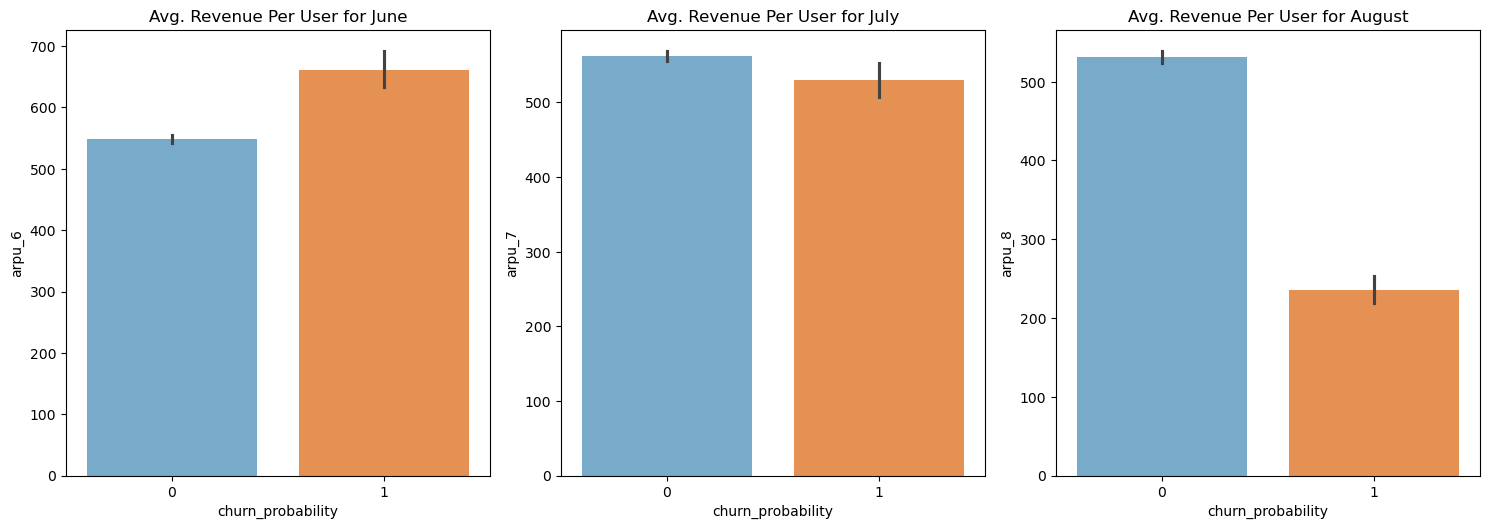

In [1281]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

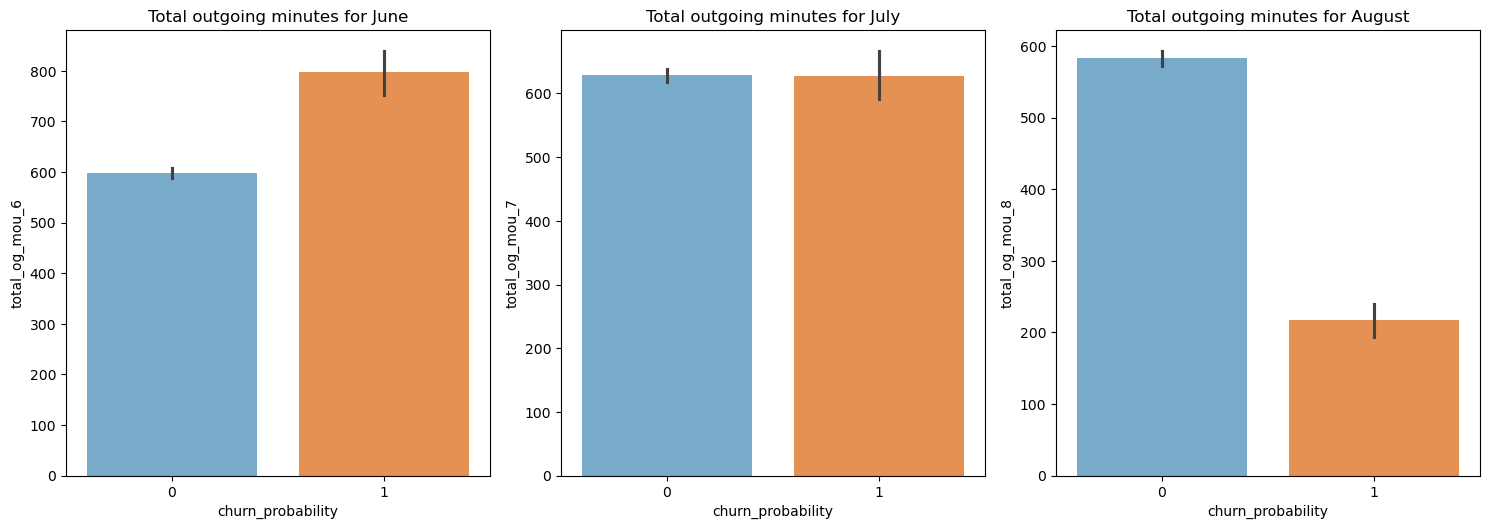

In [1282]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

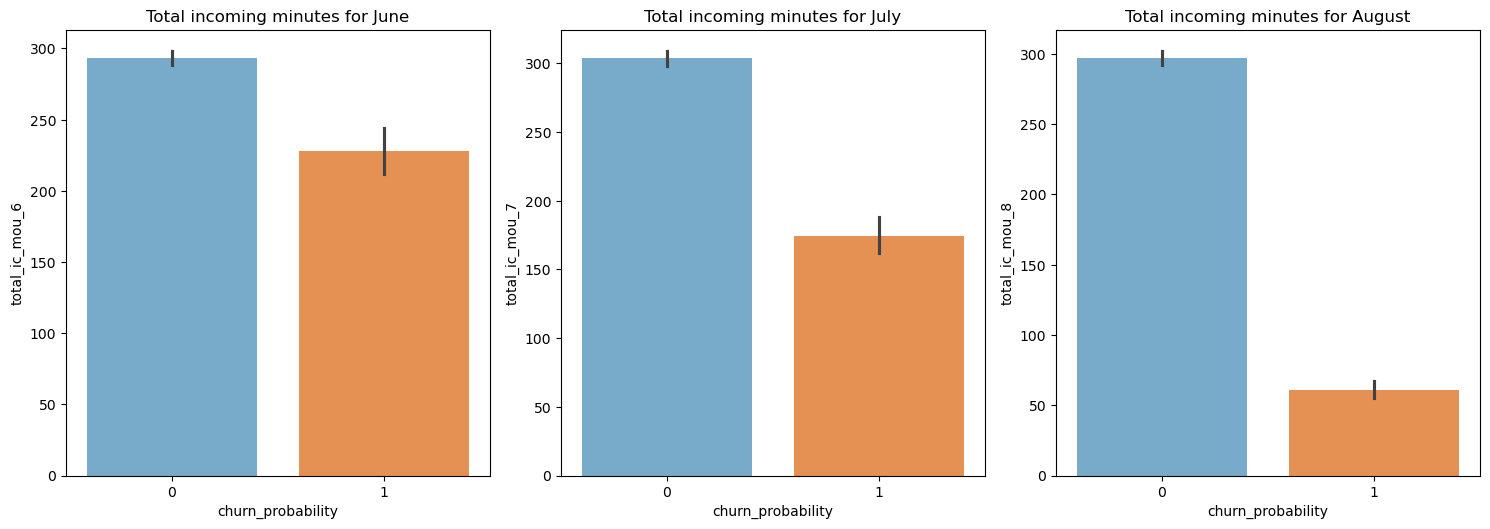

In [1283]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

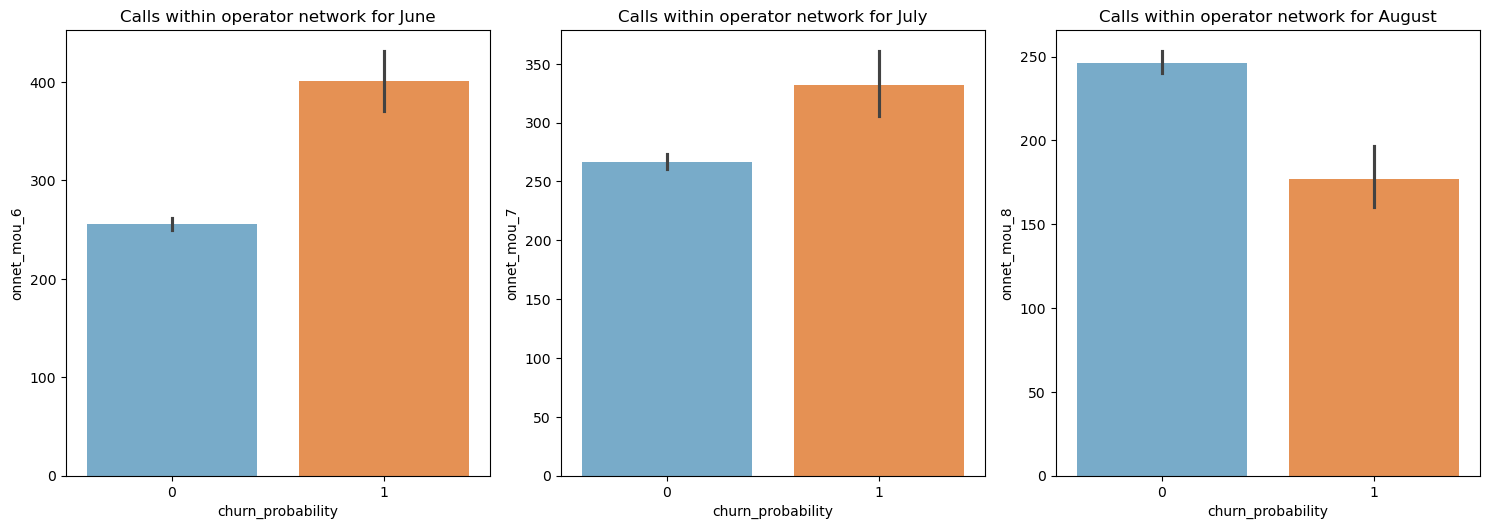

In [1284]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_df)

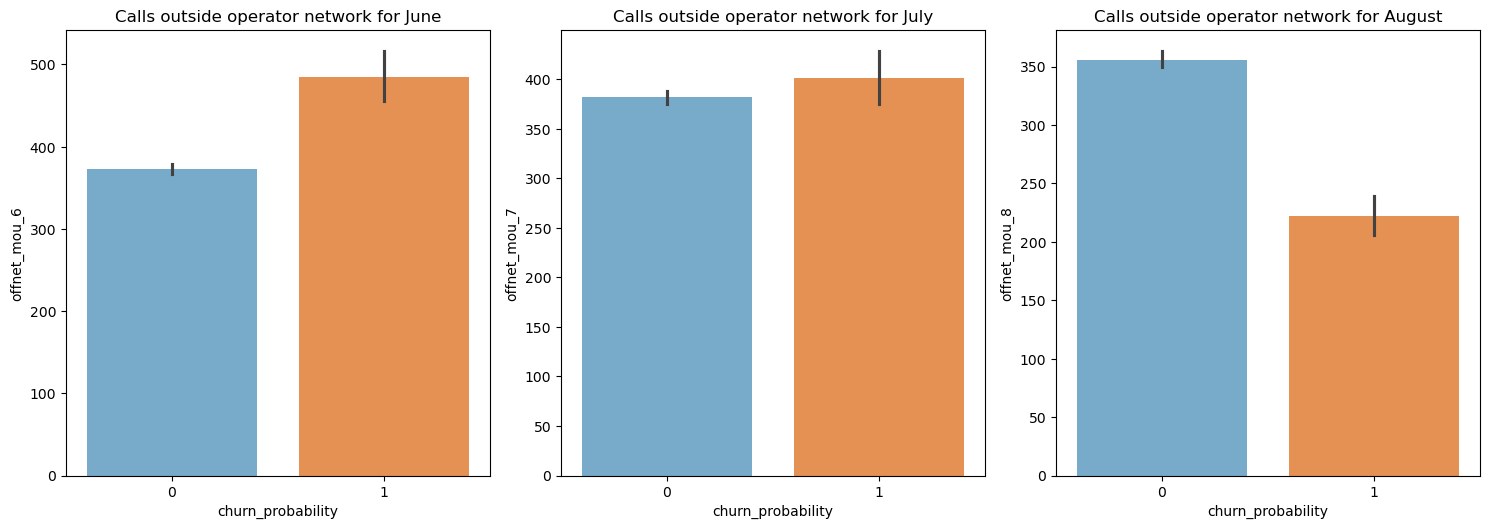

In [1285]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

In [1286]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
data2g = final_df.loc[:, final_df.columns.str.contains('2g')]
data3g = final_df.loc[:, final_df.columns.str.contains('3g')]
ic_mou_data = final_df.loc[:, final_df.columns.str.contains('ic') & final_df.columns.str.contains('mou')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]
og_mou_data = final_df.loc[:, final_df.columns.str.contains('og') & final_df.columns.str.contains('mou')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]

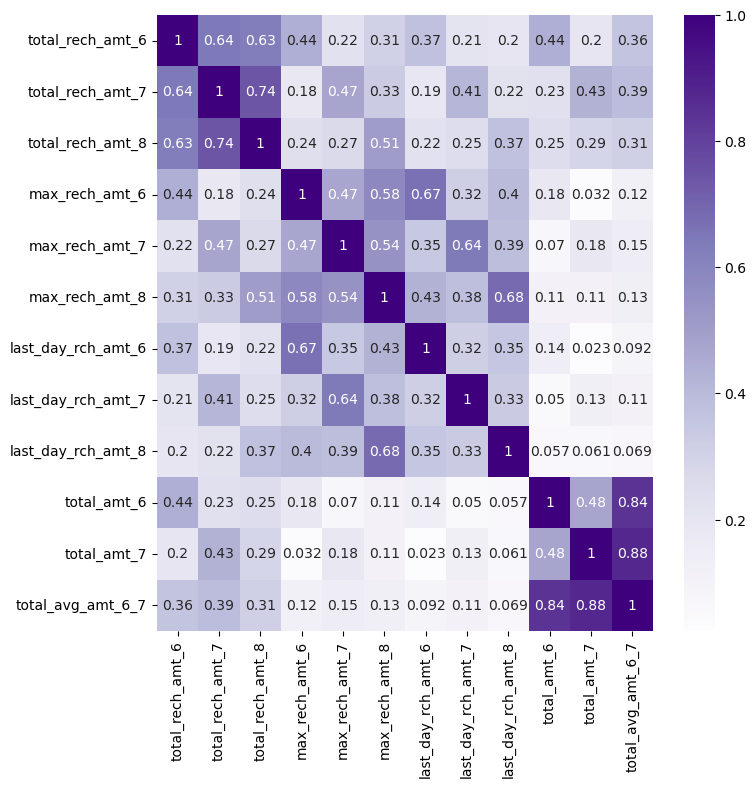

In [1287]:
# Amount data
plt.figure(figsize=(8, 8))
sns.heatmap(amount_data.corr(), annot=True, cmap='Purples')
plt.show()

##### Observation: 
- there is high corelation between total amount for month of June and July 
- simiarly there is high corelation in total recharge amount in June and July

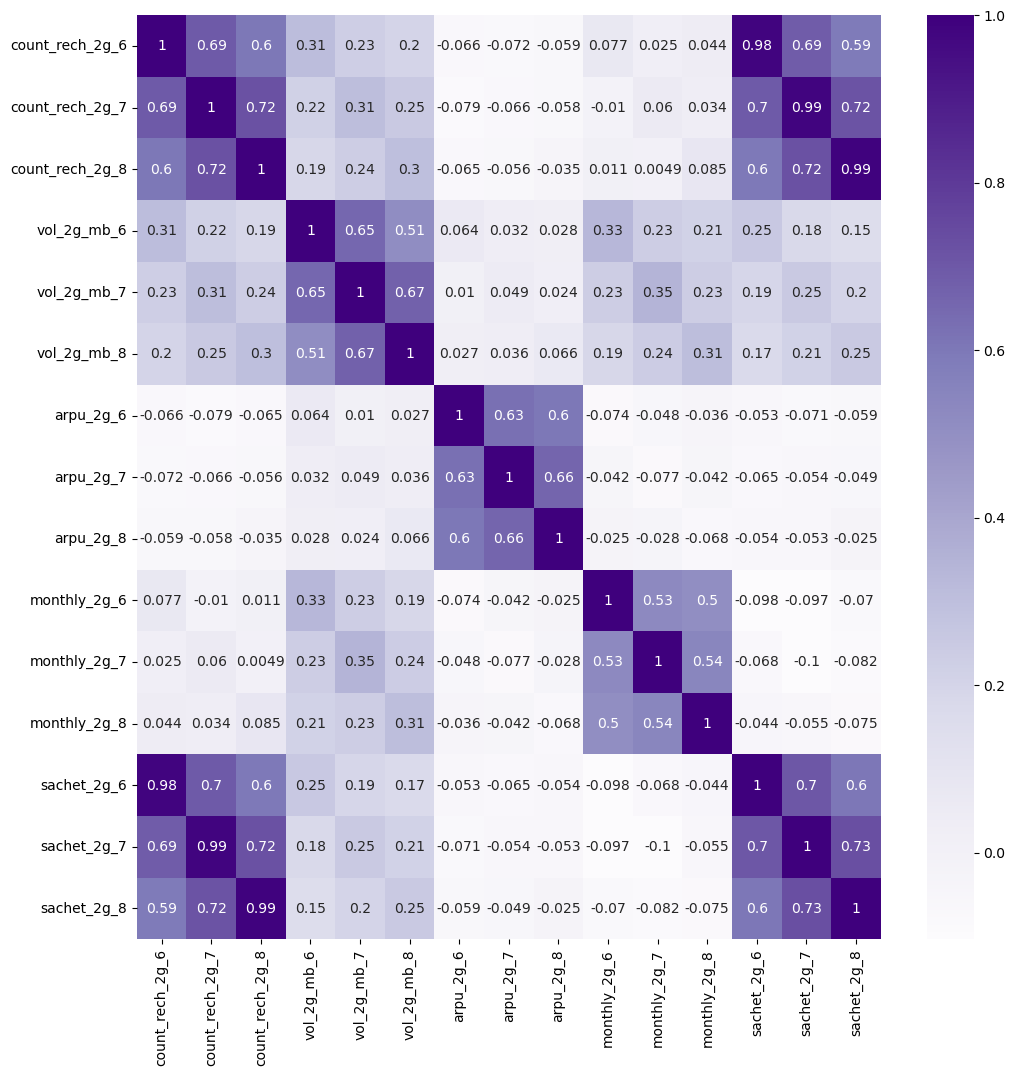

In [1288]:
# data2g data
plt.figure(figsize=(12, 12))
sns.heatmap(data2g.corr(), annot=True, cmap='Purples')
plt.show()

##### Observation:
- There is high corelation amoung recharge qty in month July and Aug

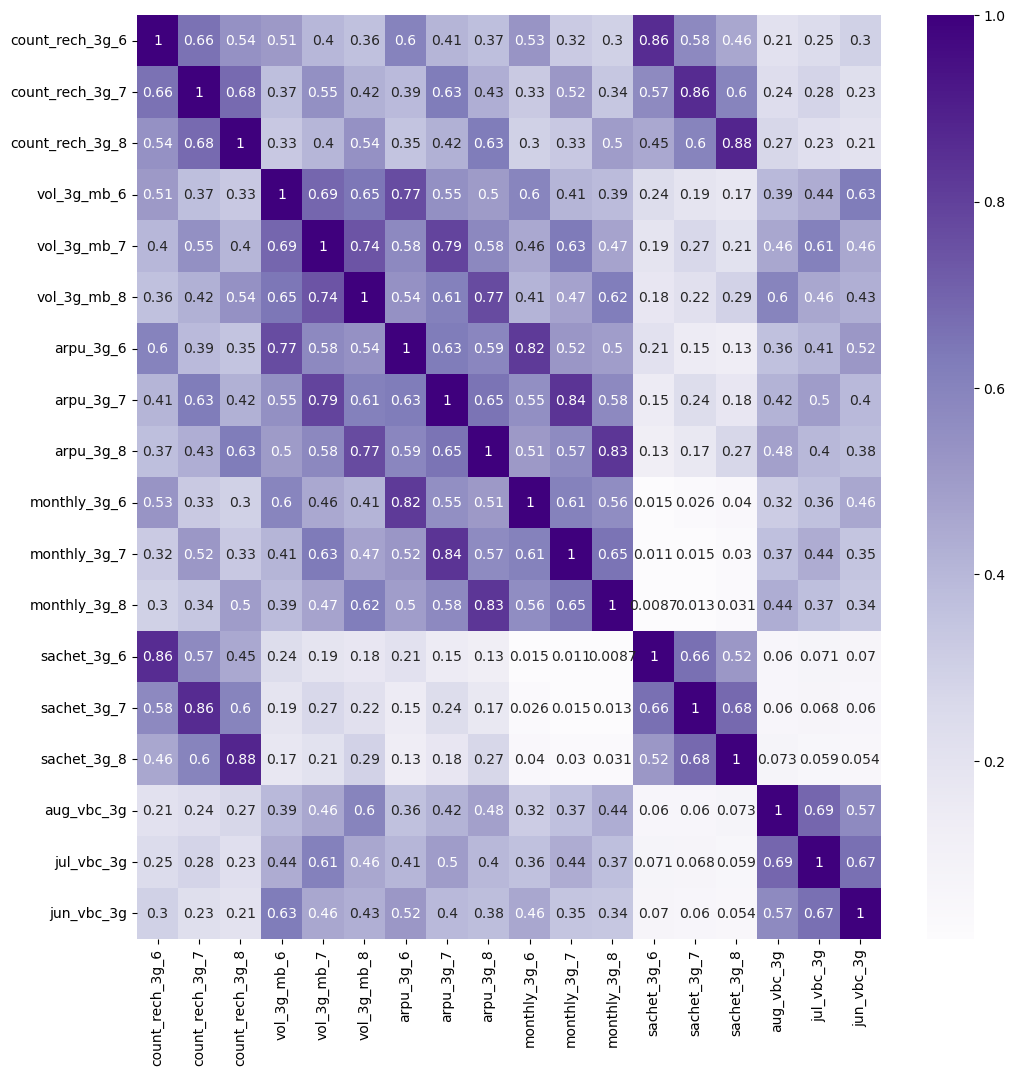

In [1289]:
# data3g data
plt.figure(figsize=(12, 12))
sns.heatmap(data3g.corr(), annot=True, cmap='Purples')
plt.show()

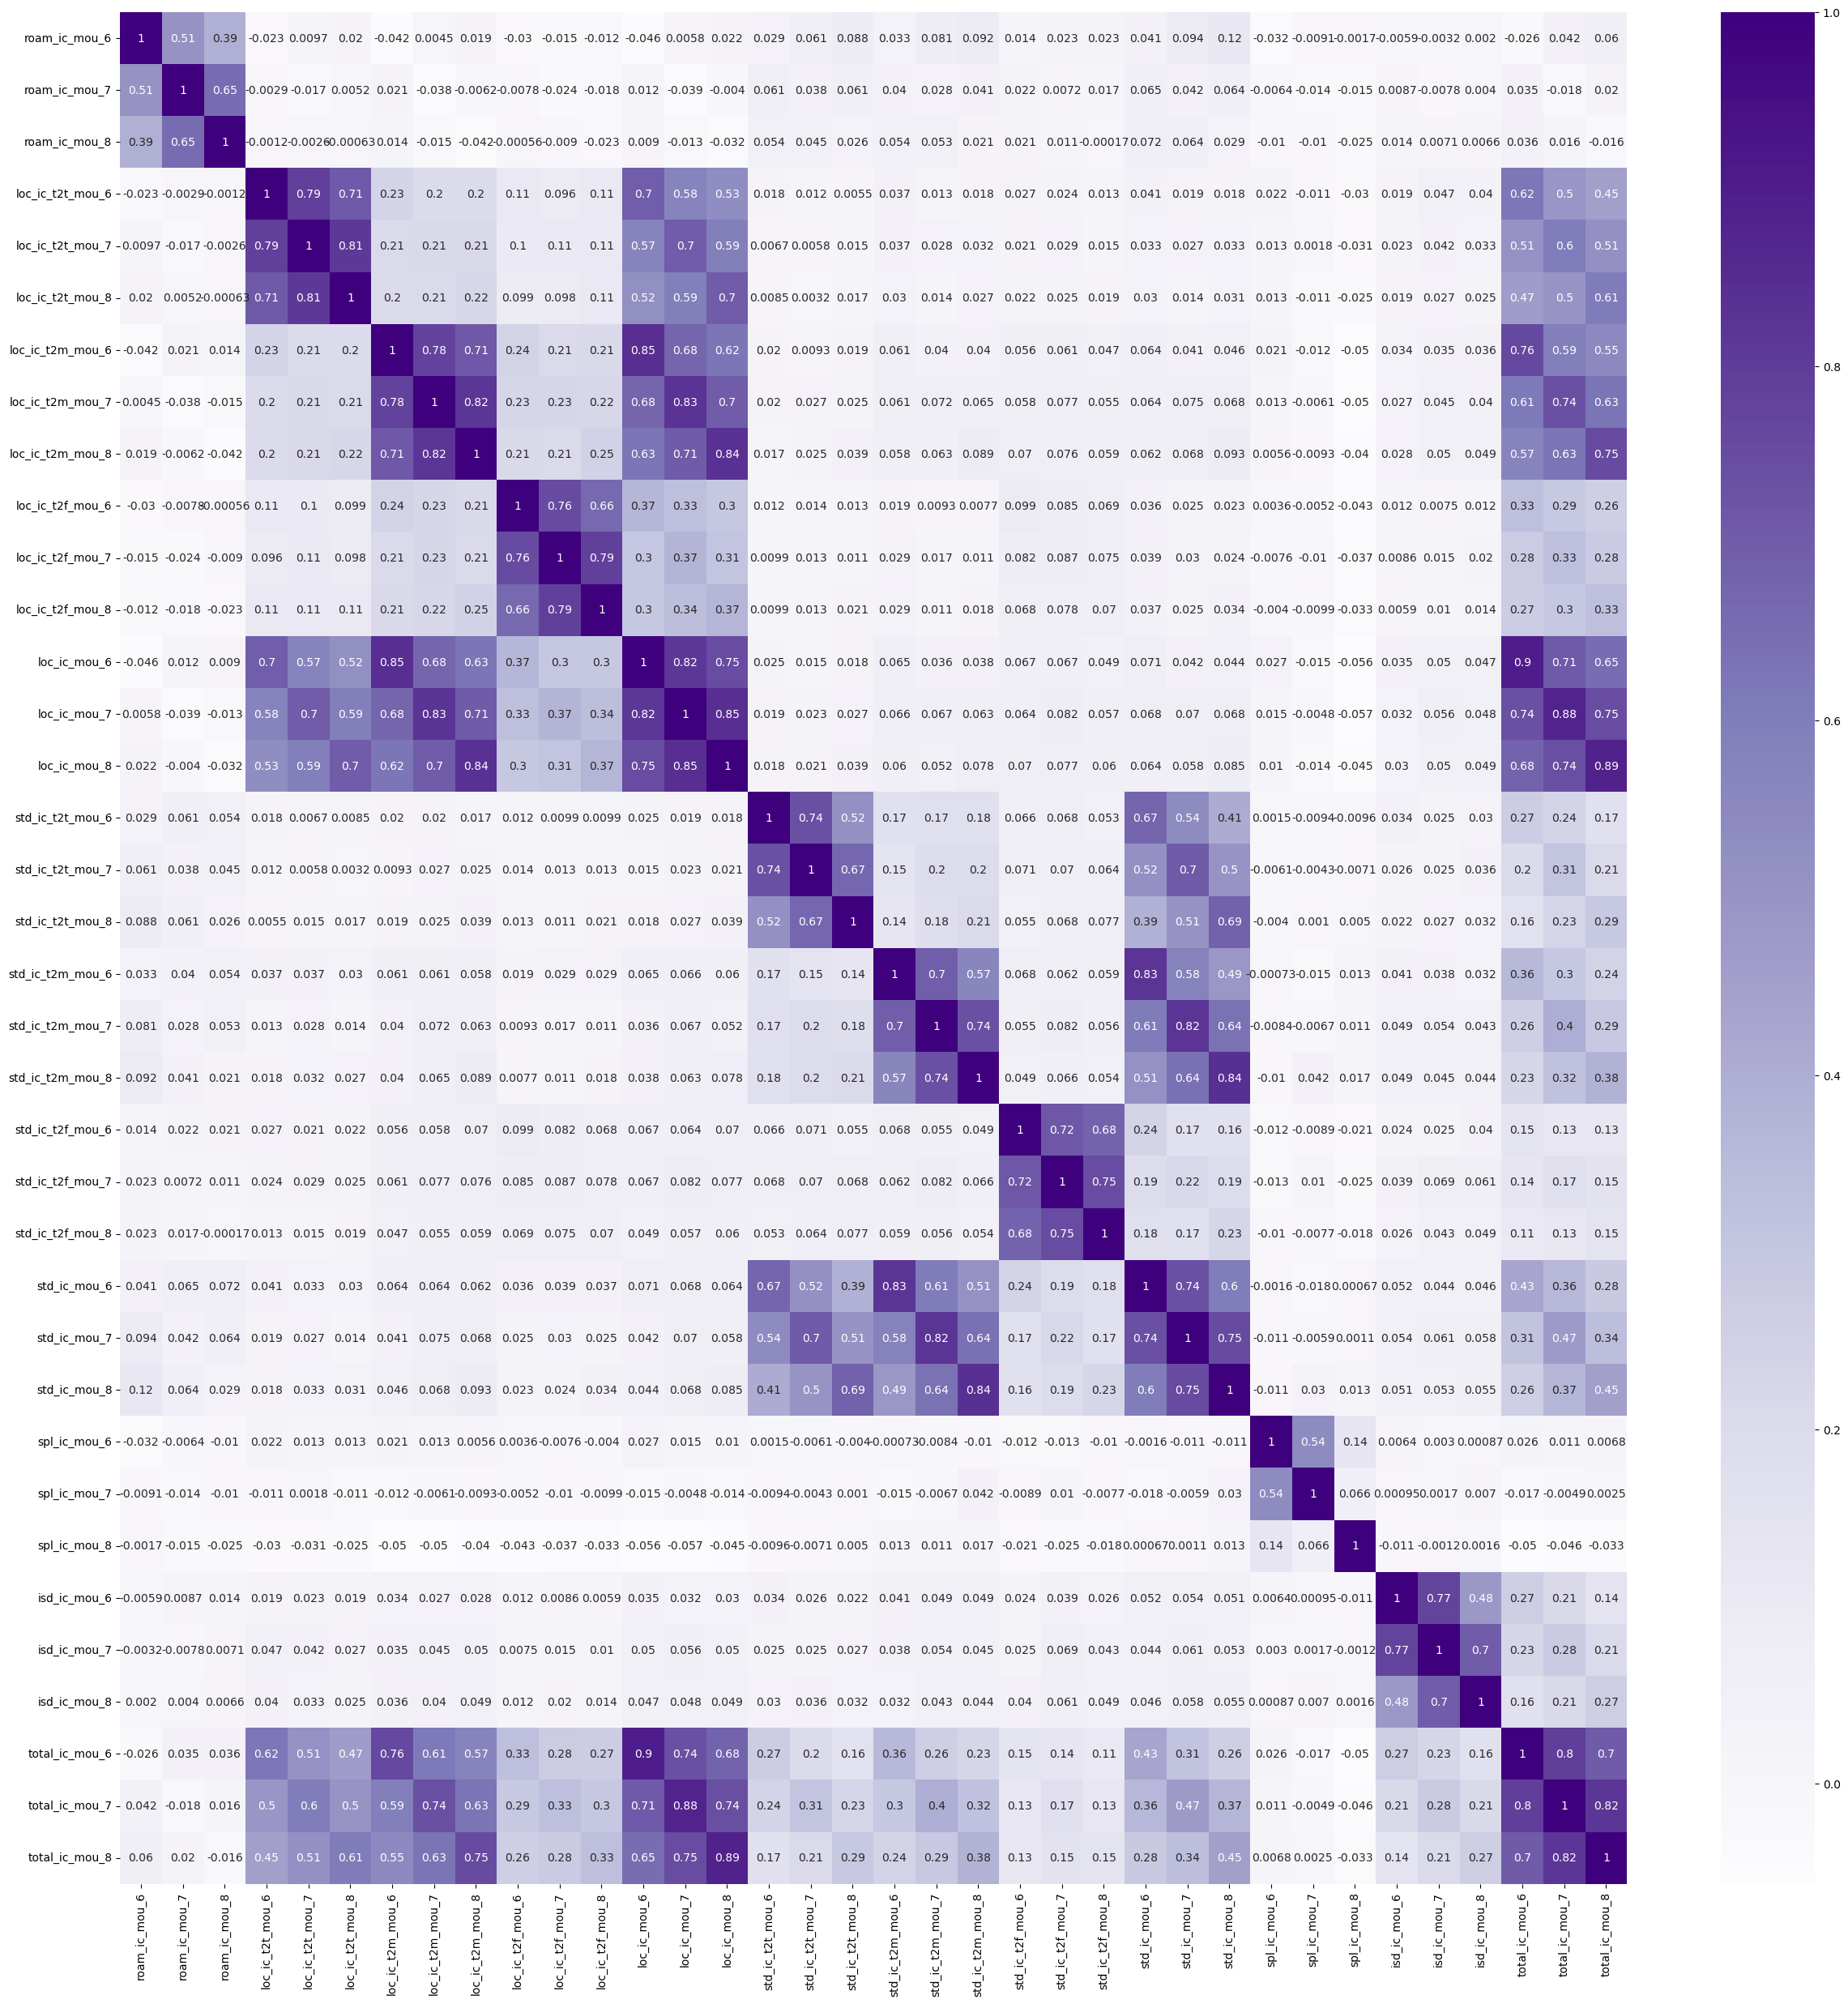

In [1290]:
#ic_mou_data
plt.figure(figsize=(30, 30))
sns.heatmap(ic_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

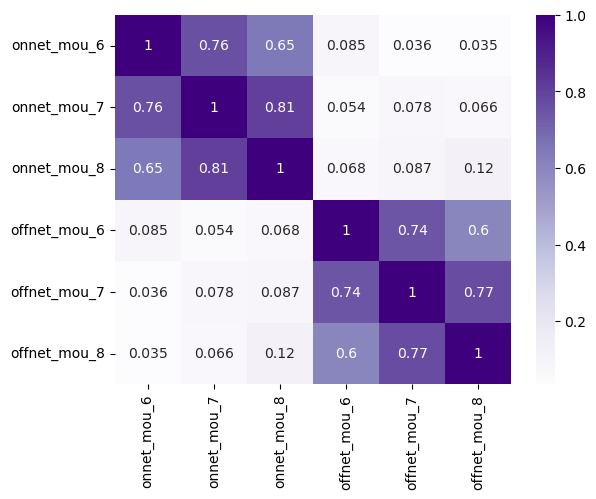

In [1291]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

##### Observation
- There is no correlation between the usage minutes for on-net and off-net calls
 - However, a significant correlation is observed between the on-net and off-net usage minutes in both months July and Aug

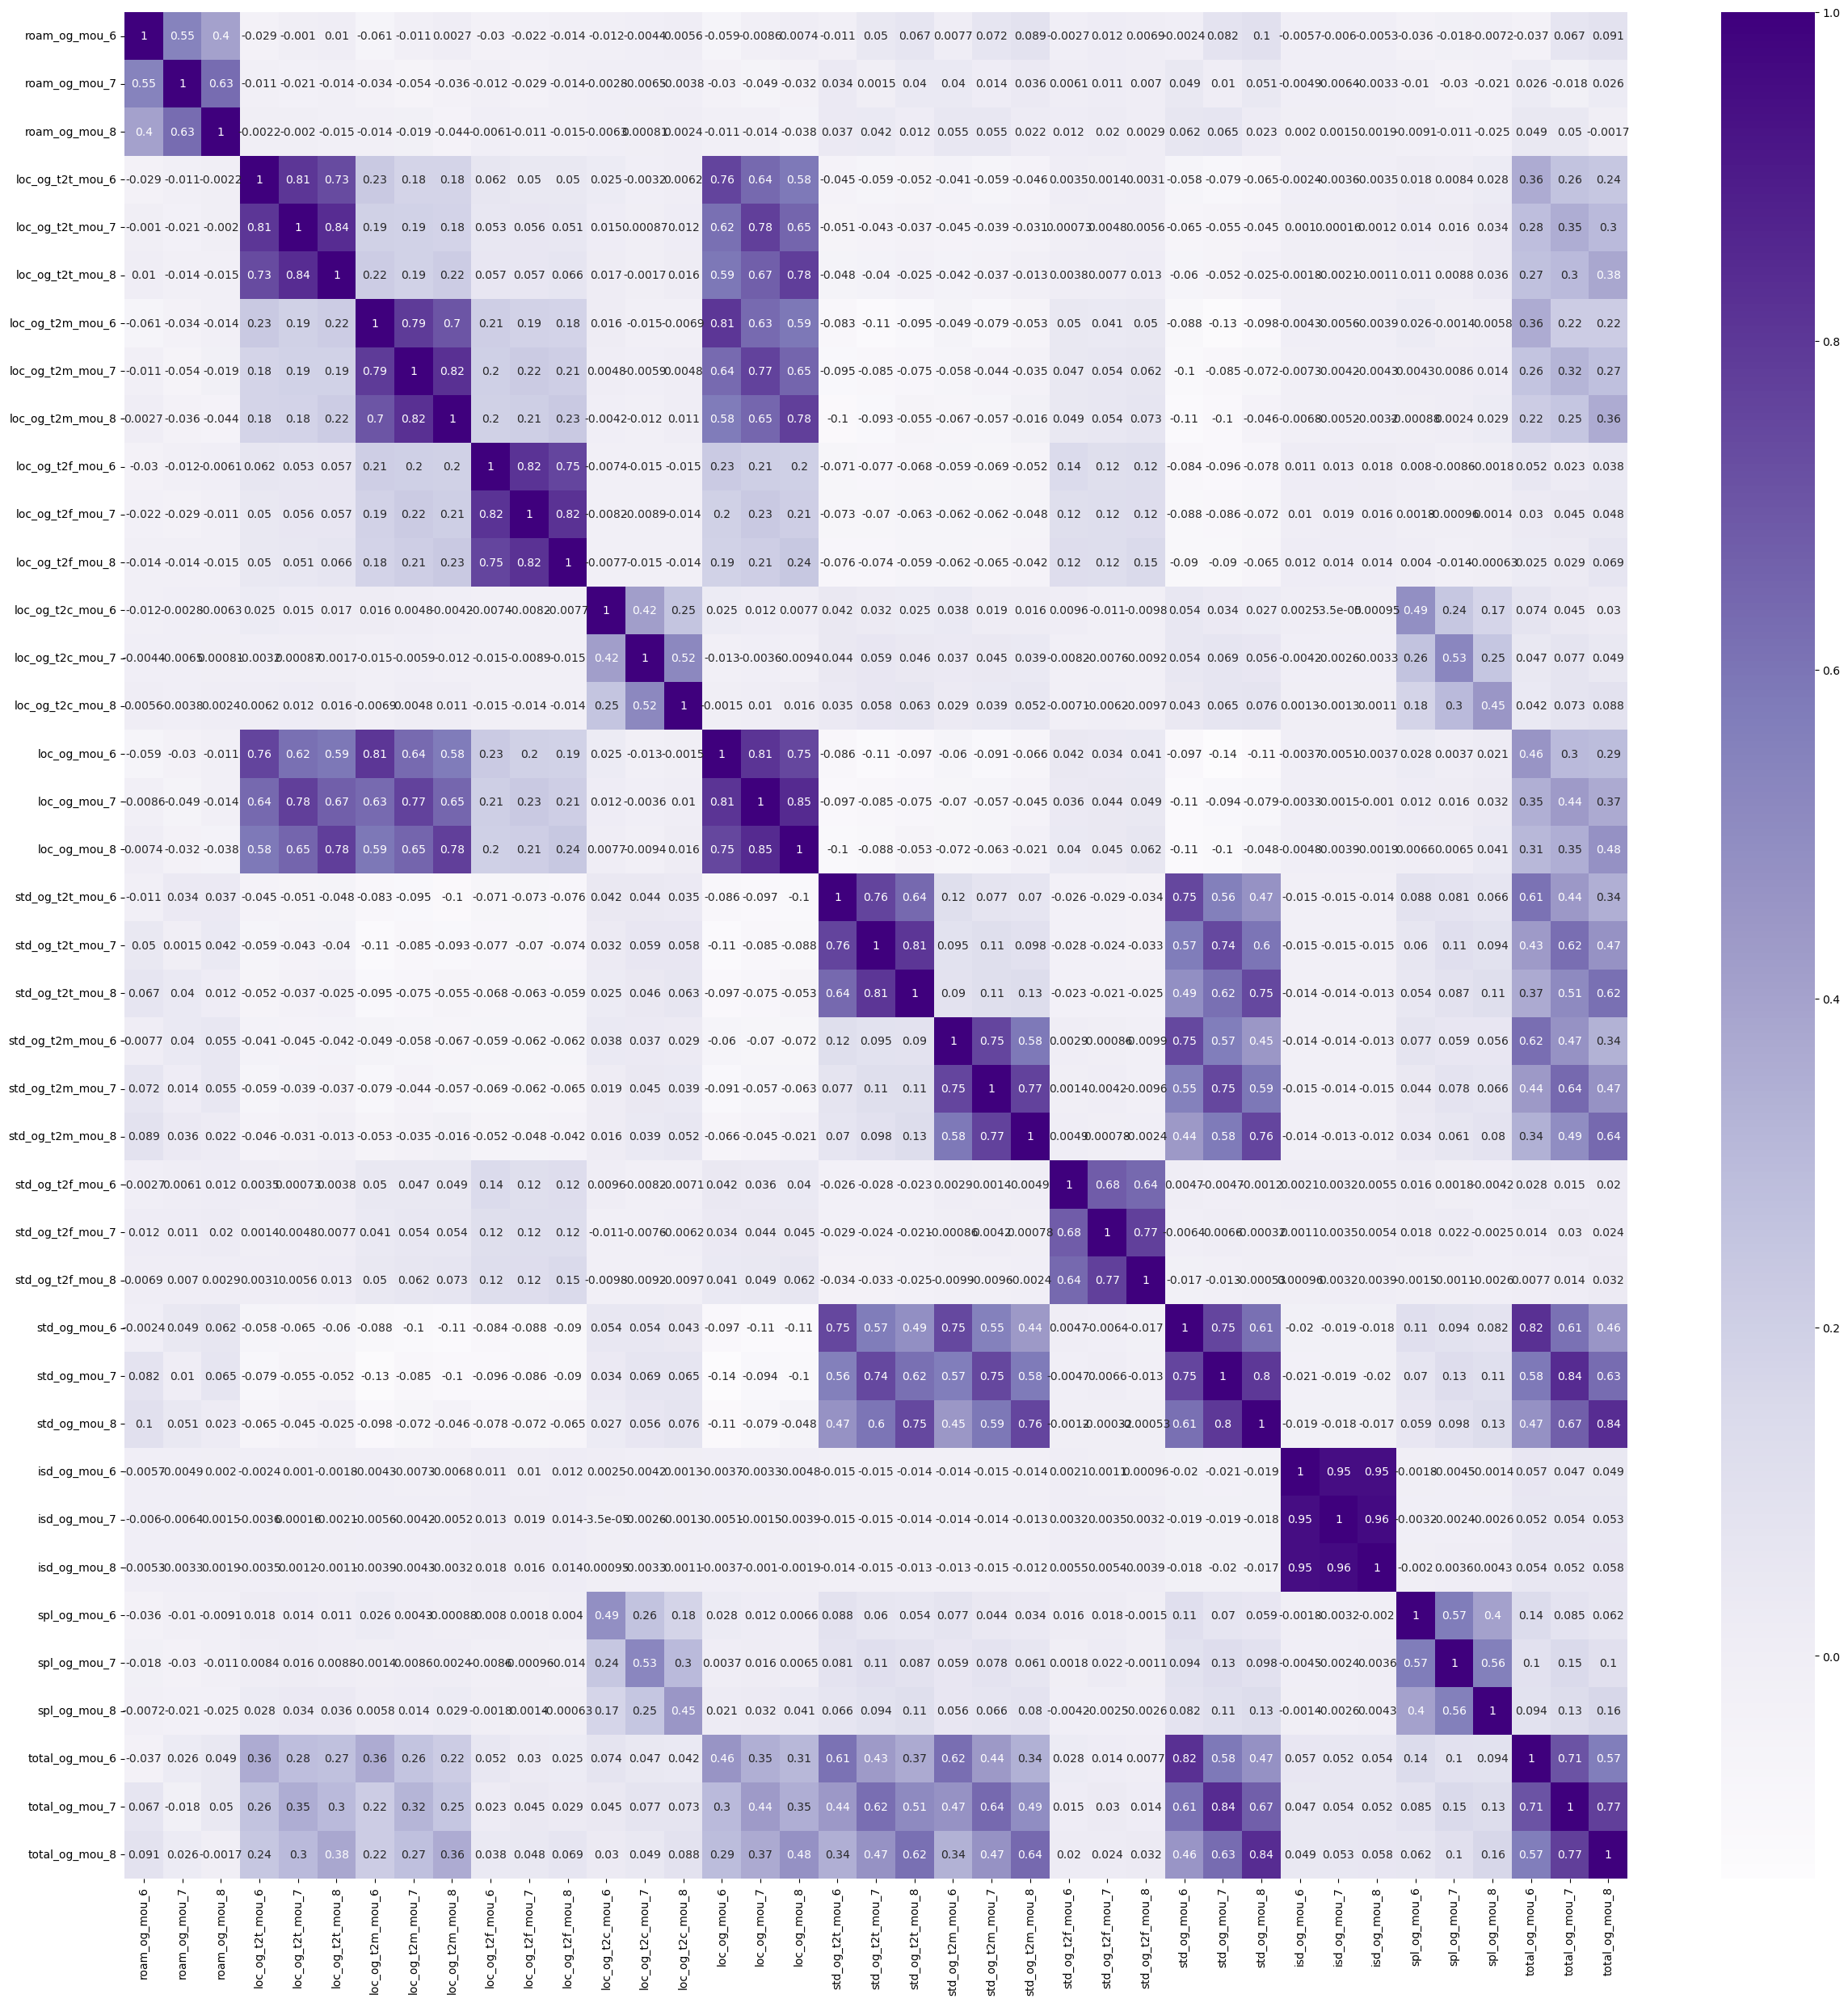

In [1292]:
#og_mou_data
plt.figure(figsize=(30,30))
sns.heatmap(og_mou_data.corr(), annot=True, cmap='Purples')
plt.show()

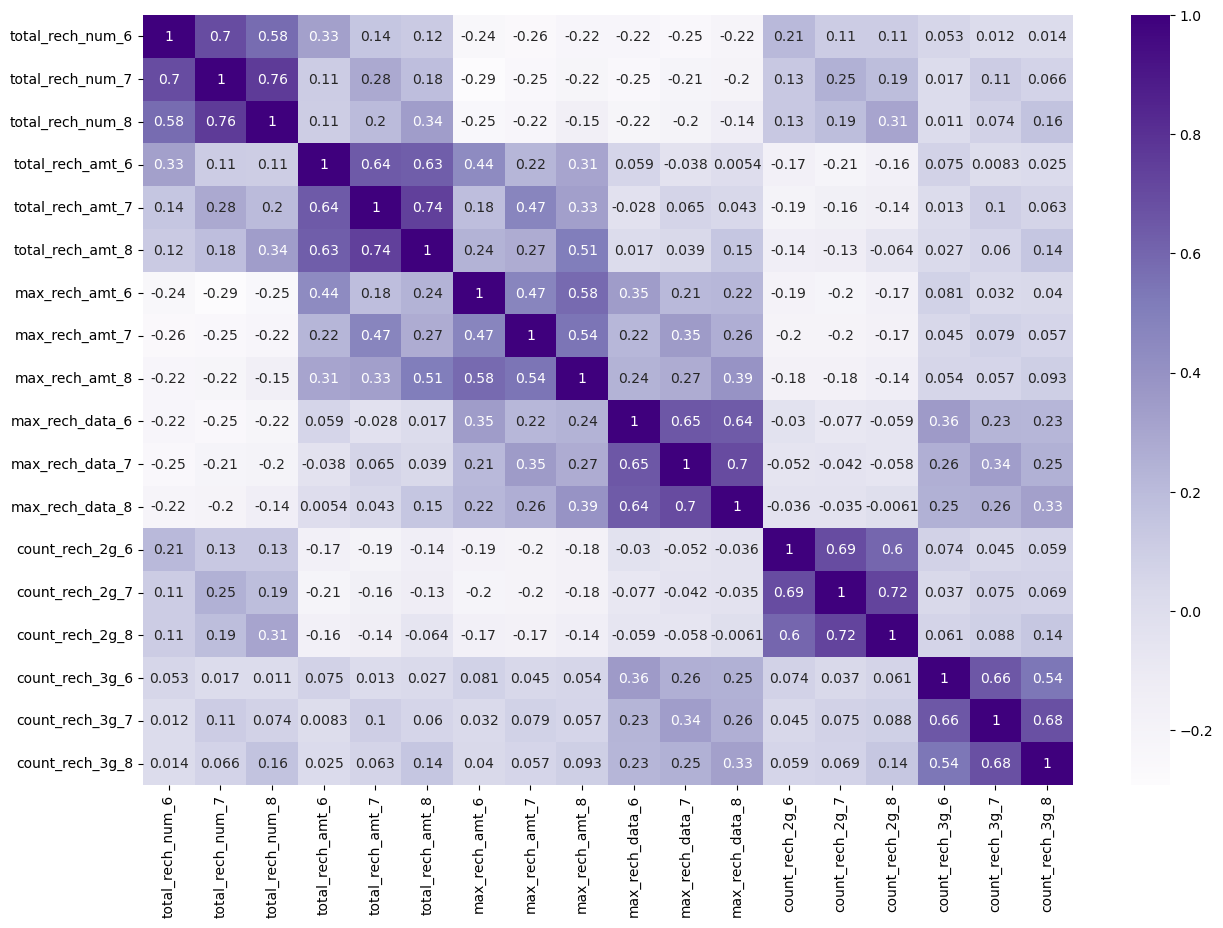

In [1293]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='Purples')
plt.show()

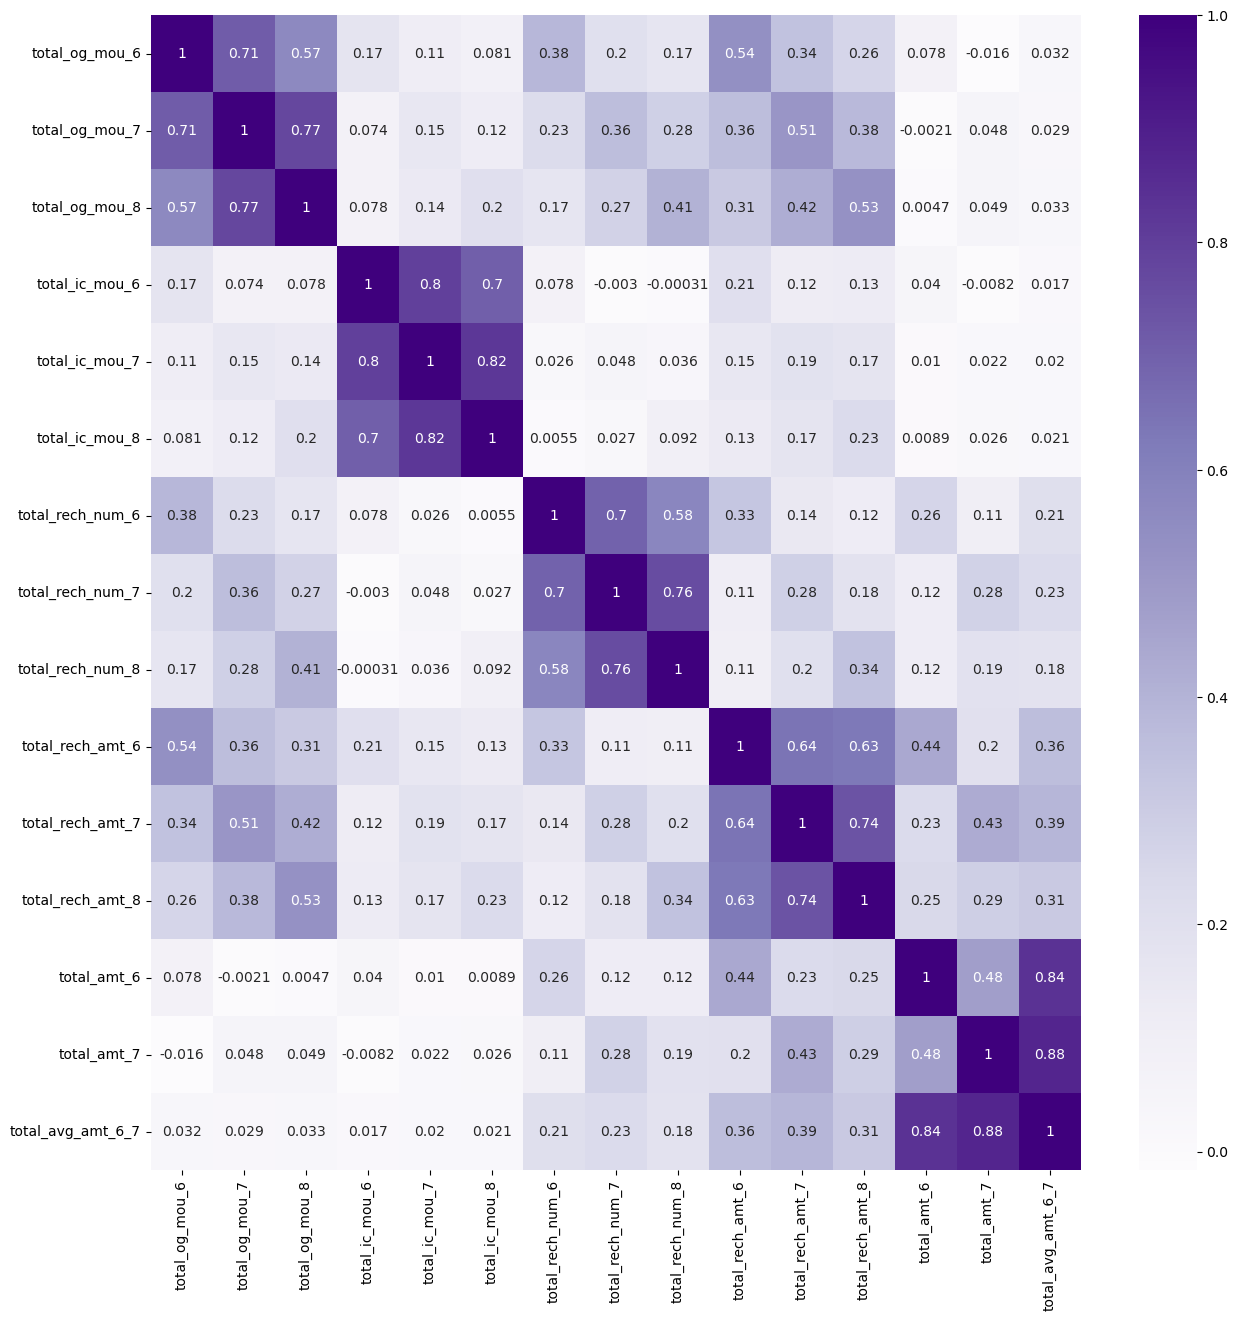

In [1294]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='Purples')
plt.show()

#### Dummy Variable for Categorical

In [1295]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [1296]:
final_df = pd.concat([final_df, dummy_df], axis=1)

In [1297]:
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

In [1298]:
final_df.shape

(20998, 155)

#### Outlier Handling 

In [1299]:
numerical_cols = list(final_df.select_dtypes(exclude='category'))

In [1300]:
# Handle outliers of numerical columns in the training set
final_df[numerical_cols] = final_df[numerical_cols].apply(outlier_handling)

In [1301]:
# Inspecting the numerical columns again in the training set
final_df.describe(percentiles=[.25, .50, .75, .90, .95, .99])

onnet_mou_6   onnet_mou_7   onnet_mou_8  offnet_mou_6  offnet_mou_7  \
count  20998.000000  20998.000000  20998.000000  20998.000000  20998.000000   
mean       4.211139      4.187525      3.998177      5.094078      5.069483   
std        2.016294      2.044529      2.066726      1.674873      1.700992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        3.017494      2.941276      2.695640      4.388754      4.341074   
50%        4.513439      4.486724      4.299799      5.462475      5.437209   
75%        5.680608      5.675452      5.506977      6.207090      6.214188   
90%        6.642910      6.671034      6.512625      6.817163      6.828526   
95%        7.046149      7.086047      6.992078      7.143970      7.150938   
99%        7.680386      7.714389      7.675314      7.757494      7.781174   
max        8.906219      9.006850      9.282992      9.031616      8.860071   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
count  20998.000000   20998.000000   20998.000000   20998.000000   
mean       4.867771       0.714730       0.566267       0.595661   
std        1.803701       1.516128       1.366637       1.367898   
min        0.000000       0.000000       0.000000       0.000000   
25%        4.077537       0.000000       0.000000       0.000000   
50%        5.296315       0.000000       0.000000       0.000000   
75%        6.098424       0.000000       0.000000       0.000000   
90%        6.736922       3.374237       2.755631       2.828260   
95%        7.067811       4.470123       4.059537       4.044865   
99%        7.686625       5.818906       5.652004       5.624508   
max        9.547408       7.868755       8.246510       8.335866   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
count   20998.000000   20998.000000   20998.000000      20998.000000   
mean        0.835726       0.677053       0.699900          3.073974   
std         1.728676       1.572577       1.561096          1.797019   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          1.805005   
50%         0.000000       0.000000       0.000000          3.290638   
75%         0.000000       0.000000       0.000000          4.407176   
90%         3.987872       3.492439       3.479392          5.234935   
95%         5.043989       4.713666       4.604635          5.767916   
99%         6.304505       6.093169       5.995640          6.920400   
max         8.236450       7.942021       8.582614          8.769092   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.083276          2.955919          4.052589          4.069228   
std            1.795294          1.832200          1.786656          1.772156   
min            0.000000          0.000000          0.000000          0.000000   
25%            1.822935          1.570697          3.095351          3.149740   
50%            3.289893          3.177220          4.404033          4.416247   
75%            4.416911          4.343188          5.342514          5.338079   
90%            5.252143          5.189010          6.044332          6.039874   
95%            5.780029          5.703314          6.409792          6.393334   
99%            6.926888          6.819465          7.024472          7.005843   
max            8.909460          9.282992          8.454856          8.424670   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
count      20998.000000      20998.000000      20998.000000      20998.000000   
mean           3.914083          0.931890          0.940227          0.910239   
std            1.871320          1.224449          1.227160          1.208081   
min            0.000000          0.000000          0.000000          0.000000   

### Model Building

In [1304]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [1305]:
print(X.shape)
print(y.shape)

(20998, 154)
(20998,)


In [1306]:
# Train test split - 80% training data, 20% validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=100)

In [1307]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_test Shape:', X_test.shape)
print('y_test Shape:', y_test.shape)

X_train Shape: (16798, 154)
y_train Shape: (16798,)
X_test Shape: (4200, 154)
y_test Shape: (4200,)


#### Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE)

In [1308]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [1309]:
print(X_train_smote.shape)
print(y_train_smote.shape)

(30800, 154)
(30800,)


#### Feature Scaling

In [1310]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

#### Unseen Data Pre Processing

In [1415]:
%%time

unseen = pd.read_csv("test.csv")

unseen.drop(cols_with_single_value, axis=1, inplace=True)
unseen.drop(columns=date_cols, axis=1, inplace=True)

# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_cols] = unseen[recharge_cols].fillna(0)
#print(unseen[recharge_cols].isnull().sum()*100/unseen.shape[1])

# Replacing NaN values in ARPU related columns with 0 in the test set
arpu_cols = unseen.columns[unseen.columns.str.contains('arpu_')]
unseen[arpu_cols] = unseen[arpu_cols].fillna(0)
#print(unseen[arpu_cols].isnull().sum()*100/unseen.shape[1])

# We'll need to convert them to the `category` data type.
unseen[cat_cols] = unseen[cat_cols].fillna(-1).astype('category')
#print(unseen[cat_cols].isnull().sum()*100/unseen.shape[1])


# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
unseen.drop(drop_data_cols, axis=1, inplace=True)

# Separate df having columns to be imputed
df_num_unseen = unseen[impute_cols_num]
churn_df_unseen = unseen.drop(impute_cols_num, axis=1)
df_imp_unseen = imputer.transform(df_num_unseen)
df_imp_unseen = pd.DataFrame(df_imp_unseen, columns=impute_cols_num)
final_unseen_df = pd.concat([df_imp_unseen, churn_df_unseen], join='inner', axis=1)

print(final_unseen_df.shape)

# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)

# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)

#final_unseen_df[numerical_cols] = scaler.transform(final_unseen_df[numerical_cols])
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(outlier_handling)

final_unseen_df.set_index('id', inplace=True)

final_unseen_scaled = pd.DataFrame(scaler.transform(final_unseen_df), columns = final_unseen_df.columns, index = final_unseen_df.index)

final_unseen_scaled.shape

(30000, 149)
CPU times: user 1min 14s, sys: 27.5 s, total: 1min 41s
Wall time: 1min 39s


(30000, 154)

In [1416]:
final_unseen_scaled.isna().sum()

onnet_mou_6             0
onnet_mou_7             0
onnet_mou_8             0
offnet_mou_6            0
offnet_mou_7            0
offnet_mou_8            0
roam_ic_mou_6           0
roam_ic_mou_7           0
roam_ic_mou_8           0
roam_og_mou_6           0
roam_og_mou_7           0
roam_og_mou_8           0
loc_og_t2t_mou_6        0
loc_og_t2t_mou_7        0
loc_og_t2t_mou_8        0
loc_og_t2m_mou_6        0
loc_og_t2m_mou_7        0
loc_og_t2m_mou_8        0
loc_og_t2f_mou_6        0
loc_og_t2f_mou_7        0
loc_og_t2f_mou_8        0
loc_og_t2c_mou_6        0
loc_og_t2c_mou_7        0
loc_og_t2c_mou_8        0
loc_og_mou_6            0
loc_og_mou_7            0
loc_og_mou_8            0
std_og_t2t_mou_6        0
std_og_t2t_mou_7        0
std_og_t2t_mou_8        0
std_og_t2m_mou_6        0
std_og_t2m_mou_7        0
std_og_t2m_mou_8        0
std_og_t2f_mou_6        0
std_og_t2f_mou_7        0
std_og_t2f_mou_8        0
std_og_mou_6            0
std_og_mou_7            0
std_og_mou_8

### Model 1 Logistic Regression with PCA and Hyperparameter Tuning

In [1315]:
pca = PCA()

In [1316]:
pca_components = pca.fit_transform(X_train)
pca_components

array([[-4.89085664e-01,  2.83715755e+00,  3.62035943e+00, ...,
         3.44071852e-13,  1.22548979e-16, -9.30579297e-15],
       [-6.47600567e+00, -4.59799754e+00, -1.14580321e+00, ...,
        -1.79902032e-14,  3.28782960e-15,  1.66995599e-14],
       [-1.19215656e+01, -4.15668288e+00,  2.45700465e+00, ...,
         1.00792998e-14,  4.06739692e-16, -3.81195446e-16],
       ...,
       [ 3.92520242e+00,  3.86956618e+00, -2.86508448e-01, ...,
         5.05068670e-15,  3.48510342e-16, -4.94915450e-16],
       [ 1.23246908e+01, -8.91562760e-01, -1.74475630e+00, ...,
        -6.54723640e-16,  2.04517628e-16, -3.31474430e-16],
       [ 2.52715271e+01, -4.94131816e+00,  6.79110471e+00, ...,
        -1.02634551e-15,  5.97647600e-16,  1.76777164e-16]])

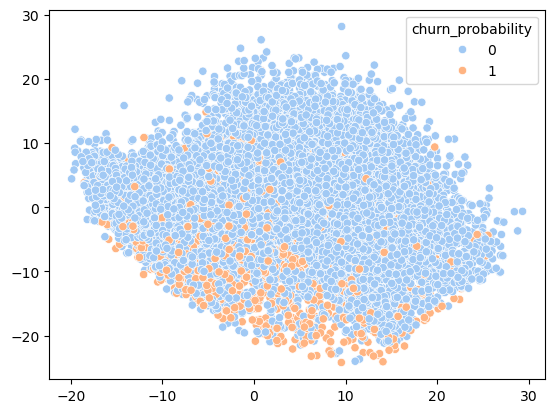

In [1317]:
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

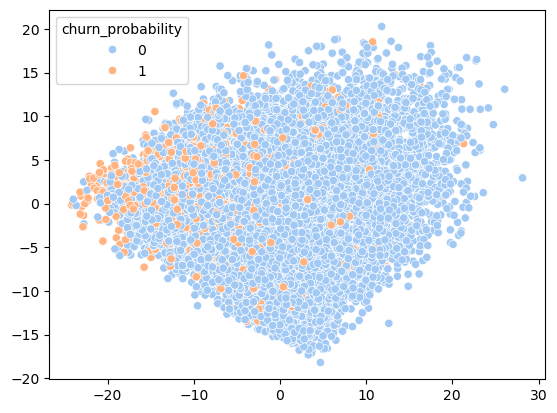

In [1318]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

##### Observation:
- As we can see, there is a clear class imbalance and we have addressed this below using SMOTE

In [1319]:
# Instantiate PCA
pca = PCA(n_components=0.95, random_state= 42)
# Fit train set on PCA
pca_components = pca.fit(X_train_scaled)
pca_components

PCA(n_components=0.95, random_state=42)

In [1320]:
# Principal components
pca_components.components_

array([[-0.14000755, -0.14943794, -0.14663547, ...,  0.01192671,
         0.10015856,  0.01350778],
       [-0.03523571, -0.01450941,  0.03109327, ...,  0.01552458,
         0.11866586,  0.00787578],
       [ 0.01969658, -0.03741439, -0.02875982, ..., -0.01972311,
         0.05536805, -0.00516568],
       ...,
       [ 0.11759253, -0.04328628, -0.04365055, ..., -0.00305904,
        -0.02648304, -0.01590501],
       [-0.05411282, -0.01276187,  0.14307948, ..., -0.00630665,
         0.00085909,  0.01636235],
       [-0.04560972,  0.10257047,  0.18448857, ...,  0.01185397,
         0.00567419, -0.01198718]])

In [1321]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca_components.explained_variance_ratio_)
print(len(variance_cumu))
print(variance_cumu)

71
[0.15670354 0.2899033  0.34947237 0.40413601 0.44311441 0.47835979
 0.50608233 0.53277412 0.55428294 0.57393416 0.59328577 0.61058985
 0.62761049 0.6418125  0.65574185 0.66823488 0.68026922 0.69169946
 0.70285977 0.7131568  0.72306305 0.73262906 0.74191065 0.75078159
 0.75916681 0.76722768 0.77517229 0.78261289 0.78972426 0.79639358
 0.80274478 0.80897153 0.8150983  0.82093433 0.8267436  0.83228596
 0.83755191 0.84269918 0.84773781 0.85260371 0.85730822 0.86193306
 0.86648082 0.87072205 0.87481827 0.8789049  0.88289431 0.88676505
 0.89049503 0.89418183 0.89779786 0.9013339  0.9047891  0.90809938
 0.9113549  0.91449951 0.91756256 0.92053167 0.92342935 0.92627851
 0.92905999 0.93172526 0.93432254 0.93683718 0.93915193 0.94141495
 0.94363392 0.9457675  0.94775393 0.94967143 0.95153715]


Text(0, 0.5, 'Cumulative Variance')

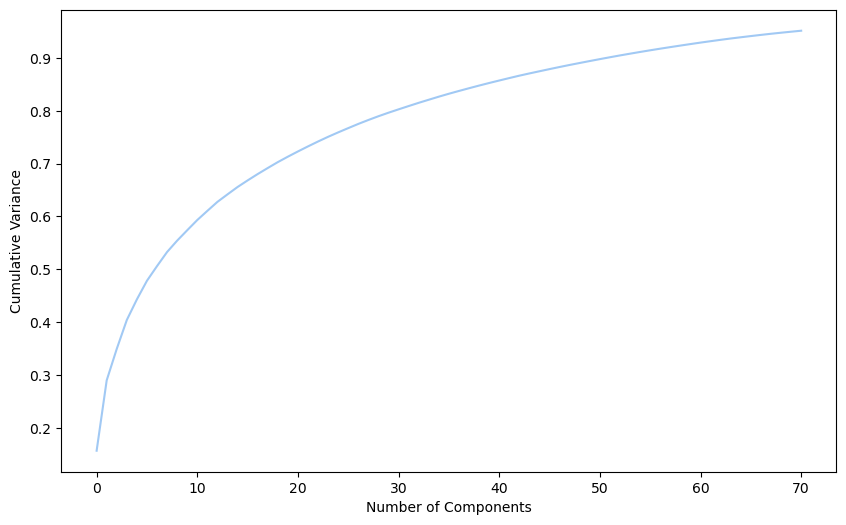

In [1322]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [1327]:
# Get top features from PC1 and PC2
top_features_pca = pd.DataFrame({'Feature': X_train_scaled.columns, 'PC1': pca.components_[0], 'PC2': pca.components_[1]})
top_features_pca = top_features_pca.sort_values(by=['PC1', 'PC2'], ascending=False)
print(top_features_pca.head(25))

                  Feature       PC1       PC2
149         fb_user_6_1.0  0.111463  0.123319
147         fb_user_7_1.0  0.104136  0.140442
111           vol_2g_mb_6  0.100402  0.090359
152  night_pck_user_6_0.0  0.100159  0.118666
102       max_rech_data_6  0.097202  0.132976
112           vol_2g_mb_7  0.093152  0.103884
150  night_pck_user_7_0.0  0.093138  0.134286
103       max_rech_data_7  0.092692  0.149458
105       count_rech_2g_6  0.086166  0.057135
120             arpu_2g_6  0.081132  0.114220
126           sachet_2g_6  0.080105  0.030373
114           vol_3g_mb_6  0.079917  0.125528
115           vol_3g_mb_7  0.079891  0.144308
106       count_rech_2g_7  0.078196  0.073280
145         fb_user_8_1.0  0.075660  0.147995
121             arpu_2g_7  0.074390  0.131405
117             arpu_3g_6  0.073033  0.116950
108       count_rech_3g_6  0.072541  0.101208
127           sachet_2g_7  0.071124  0.045667
138            jun_vbc_3g  0.070316  0.113120
118             arpu_3g_7  0.06905

In [1324]:
pca_final = IncrementalPCA(n_components=71)

In [1373]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train_scaled)

In [1374]:
# Predict values on the validation set
X_test_pca = pca_final.transform(X_test_scaled)

In [1336]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Specifying score as recall as we are more focused on achieving higher sensitivity than accuracy
lr_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

In [1338]:
X_train_pca.shape

(30800, 71)

In [1339]:
y_train

(16798,)

In [1340]:
lr_grid_search.fit(X_train_pca, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga']},
             return_train_score=True, scoring='recall', verbose=1)

In [1342]:
# Predict values on the training set
y_train_pred = lr_grid_search.predict(X_train_pca)

In [1341]:
# Get the best parameters and estimator
lr_best_params = lr_grid_search.best_params_
lr_best_estimator = lr_grid_search.best_estimator_

In [1345]:
calculate_classification_metrics(y_train_smote, y_train_pred)

Confusion Matrix

[[13443  1957]
 [ 2521 12879]]


Metric   Value
0             Accuracy  0.8546
1          Sensitivity  0.8363
2          Specificity  0.8729
3            Precision  0.8681
4  False Positive Rate  0.1271
5   True Positive Rate  0.8363

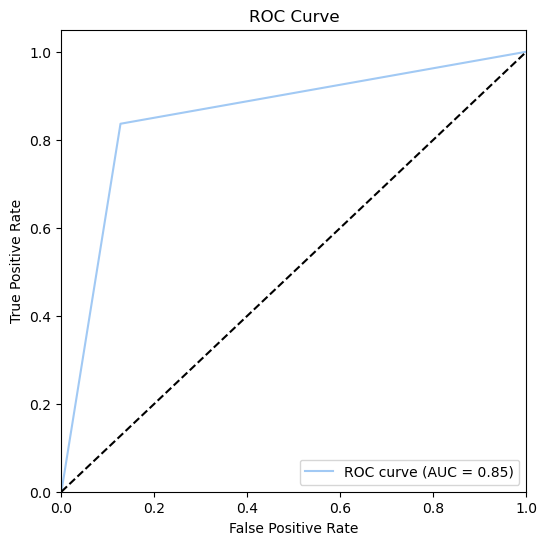

In [1518]:
plot_roc_curve(y_train_smote, y_train_pred)

#### Predict on Unseen Data

In [1360]:
final_unseen_scaled.isnull().sum()

onnet_mou_6                 0
onnet_mou_7                 0
onnet_mou_8                 0
offnet_mou_6                0
offnet_mou_7                0
offnet_mou_8                0
roam_ic_mou_6               0
roam_ic_mou_7               0
roam_ic_mou_8               0
roam_og_mou_6               0
roam_og_mou_7               0
roam_og_mou_8               0
loc_og_t2t_mou_6            0
loc_og_t2t_mou_7            0
loc_og_t2t_mou_8            0
loc_og_t2m_mou_6            0
loc_og_t2m_mou_7            0
loc_og_t2m_mou_8            0
loc_og_t2f_mou_6            0
loc_og_t2f_mou_7            0
loc_og_t2f_mou_8            0
loc_og_t2c_mou_6            0
loc_og_t2c_mou_7            0
loc_og_t2c_mou_8            0
loc_og_mou_6                0
loc_og_mou_7                0
loc_og_mou_8                0
std_og_t2t_mou_6            0
std_og_t2t_mou_7            0
std_og_t2t_mou_8            0
std_og_t2m_mou_6            0
std_og_t2m_mou_7            0
std_og_t2m_mou_8            0
std_og_t2f

In [1372]:
# Apply PCA
X_unseen_pca = pca_final.transform(final_unseen_scaled)

In [1375]:
# Predict values on the training set
y_unseen_pred = lr_grid_search.predict(X_unseen_pca)

In [1379]:
index = final_unseen_scaled.index
X_unseen_pred_series = pd.Series(X_unseen_pred, index=index, name='churn_probability')

In [1381]:
X_unseen_pred_df = X_unseen_pred_series.reset_index()

In [1383]:
X_unseen_pred_df['churn_probability'].value_counts()

0    30000
Name: churn_probability, dtype: int64

### Model 2. Logistic Regression with Recursive Feature Elimination (RFE)


In [1403]:
%%time
# Select top 30 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

CPU times: user 5min 49s, sys: 1.74 s, total: 5min 51s
Wall time: 5min 54s


In [1404]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 59),
 ('onnet_mou_7', False, 26),
 ('onnet_mou_8', False, 25),
 ('offnet_mou_6', False, 92),
 ('offnet_mou_7', False, 16),
 ('offnet_mou_8', False, 13),
 ('roam_ic_mou_6', False, 69),
 ('roam_ic_mou_7', False, 34),
 ('roam_ic_mou_8', True, 1),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', False, 28),
 ('roam_og_mou_8', True, 1),
 ('loc_og_t2t_mou_6', False, 94),
 ('loc_og_t2t_mou_7', False, 66),
 ('loc_og_t2t_mou_8', False, 74),
 ('loc_og_t2m_mou_6', False, 22),
 ('loc_og_t2m_mou_7', False, 36),
 ('loc_og_t2m_mou_8', False, 23),
 ('loc_og_t2f_mou_6', False, 119),
 ('loc_og_t2f_mou_7', False, 38),
 ('loc_og_t2f_mou_8', False, 37),
 ('loc_og_t2c_mou_6', False, 79),
 ('loc_og_t2c_mou_7', False, 129),
 ('loc_og_t2c_mou_8', False, 109),
 ('loc_og_mou_6', False, 21),
 ('loc_og_mou_7', False, 15),
 ('loc_og_mou_8', False, 14),
 ('std_og_t2t_mou_6', False, 32),
 ('std_og_t2t_mou_7', False, 27),
 ('std_og_t2t_mou_8', False, 24),
 ('std_og_t2m_mou_6', False, 33),
 ('s

In [1405]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['roam_ic_mou_8', 'roam_og_mou_8', 'loc_ic_t2t_mou_7',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'spl_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8',
       'night_pck_user_8_0.0'],
      dtype='object')

In [1406]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [1407]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [1408]:
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[13532  1868]
 [ 2540 12860]]


Metric   Value
0             Accuracy  0.8569
1          Sensitivity  0.8351
2          Specificity  0.8787
3            Precision  0.8732
4  False Positive Rate  0.1213
5   True Positive Rate  0.8351

In [1409]:
# Retain only the selected feature from the final model
X_test_scaled_final = X_test_scaled[selected_features]
X_test_scaled_final.head()

roam_ic_mou_8  roam_og_mou_8  loc_ic_t2t_mou_7  loc_ic_t2t_mou_8  \
3837       -0.665387      -0.710456         -0.630131         -0.290168   
11055      -0.665387      -0.710456         -1.797907         -1.503523   
12221      -0.665387      -0.710456         -0.936458          0.500096   
17179       0.507003       0.310656         -1.797907         -1.503523   
16047      -0.665387      -0.710456          1.009888          1.293739   

       loc_ic_t2m_mou_7  loc_ic_t2m_mou_8  loc_ic_mou_7  loc_ic_mou_8  \
3837          -1.557462         -0.780535     -1.260499     -0.619060   
11055         -2.375158         -1.877587     -2.594398     -1.984767   
12221         -1.291162         -0.008022     -1.288229      0.116259   
17179         -2.375158         -1.877587     -2.594398     -1.984767   
16047          0.136627          0.558739      0.498659      0.815106   

       spl_ic_mou_8  total_ic_mou_8  total_rech_num_7  total_rech_num_8  \
3837      -0.266206       -0.300154         -1.082799         -0.101475   
11055      2.474225       -1.317514         -1.434322         -0.619858   
12221      6.933130        0.329095          0.159277          1.437791   
17179     -0.266206       -1.395256          0.159277         -0.101475   
16047     -0.266206        0.859190         -1.887514         -0.987657   

       total_rech_amt_6  total_rech_amt_8  max_rech_amt_6  max_rech_amt_8  \
3837           0.204074          0.547510        0.794832        0.902878   
11055          0.035264          0.561889        0.794832        0.902878   
12221         -5.086412          0.669800       -4.510459        0.156583   
17179          0.347429         -0.539241        0.004934       -0.256881   
16047          0.431105         -1.678770        1.078205       -1.675565   

       last_day_rch_amt_8  max_rech_data_8  count_rech_2g_8  \
3837            -1.039975         1.790895        -0.595224   
11055           -1.039975         1.790895        -0.595224   
12221            0.724532        -0.735593        -0.595224   
17179           -1.039975        -0.735593        -0.595224   
16047           -1.039975        -0.735593        -0.595224   

       night_pck_user_8_0.0  
3837               1.363391  
11055              1.363391  
12221             -0.759323  
17179             -0.759323  
16047             -0.759323

In [1410]:
# Get the predicted values from the linear model
y_test_pred = logreg.predict(X_test_scaled_final)

In [1411]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_test, y_test_pred)
metrics_df

Confusion Matrix

[[3379  484]
 [  76  261]]


Metric   Value
0             Accuracy  0.8667
1          Sensitivity  0.7745
2          Specificity  0.8747
3            Precision  0.3503
4  False Positive Rate  0.1253
5   True Positive Rate  0.7745

#### Predict for Unseen data

In [1417]:
X_final_unseen_scaled = final_unseen_scaled[selected_features]

In [1418]:
# Get the predicted values from the linear model
y_unseen_pred = logreg.predict(X_final_unseen_scaled)

In [1419]:
index = final_unseen_scaled.index
X_unseen_pred_series = pd.Series(y_unseen_pred, index=index, name='churn_probability')
X_unseen_pred_df = X_unseen_pred_series.reset_index()
X_unseen_pred_df['churn_probability'].value_counts()

0    22462
1     7538
Name: churn_probability, dtype: int64

In [1420]:
X_unseen_pred_df.to_csv('logred_predictions.csv', index=False, header=True)

### Model 3. Random Forest Classifier with Hyperparameter Tuning

In [1421]:
max_features = int(round(np.sqrt(X_train_scaled.shape[1])))    # number of variables to consider to split each node
print(max_features)

12


In [1501]:
%%time
# Define the parameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [20,25,30,35],
#     'min_samples_split': [5],
#     'min_samples_leaf': [1, 2]
# }

param_grid_rf = {
    'n_estimators': [250,275,300], 
    'max_depth': [22],  
    'min_samples_split': [5,6,7],  
    #'min_samples_leaf': [1,2,3]  
}

# Perform Grid Search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), 
                              param_grid=param_grid_rf, 
                              cv=5, 
                              scoring='recall',
                              verbose=1,
                              return_train_score=True)
grid_search_rf.fit(X_train_scaled, y_train_smote)

# Get the best parameters and the best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for Random Forest:", best_params_rf)
print("Best F1 score for Random Forest:", best_score_rf)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Random Forest: {'max_depth': 22, 'min_samples_split': 5, 'n_estimators': 250}
Best F1 score for Random Forest: 0.9791558441558441
CPU times: user 54min 51s, sys: 22.5 s, total: 55min 14s
Wall time: 5min 12s


In [1427]:
# First Model
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

In [1443]:
# Second Model
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [1505]:
# Third Model
grid_search_rf.best_estimator_

RandomForestClassifier(max_depth=22, min_samples_split=5, n_estimators=250,
                       n_jobs=-1, random_state=42)

In [1430]:
# First Model
# Get the best model
rf_best_model = grid_search_rf.best_estimator_

# Predict on train set using the best model
y_train_pred_rf = rf_best_model.predict(X_train_scaled)

In [1433]:
y_test_pred_rf = rf_best_model.predict(X_test_scaled)

In [1434]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_test, y_test_pred_rf)
metrics_df

Confusion Matrix

[[3711  152]
 [ 123  214]]


Metric   Value
0             Accuracy  0.9345
1          Sensitivity  0.6350
2          Specificity  0.9607
3            Precision  0.5847
4  False Positive Rate  0.0393
5   True Positive Rate  0.6350

In [1445]:
# First Model
# Get the best model
rf_best_model2 = grid_search_rf.best_estimator_

# Predict on train set using the best model
y_train_pred_rf2 = rf_best_model2.predict(X_train_scaled)

In [1446]:
y_test_pred_rf2 = rf_best_model2.predict(X_test_scaled)

In [1447]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_test, y_test_pred_rf2)
metrics_df

Confusion Matrix

[[3714  149]
 [ 126  211]]


Metric   Value
0             Accuracy  0.9345
1          Sensitivity  0.6261
2          Specificity  0.9614
3            Precision  0.5861
4  False Positive Rate  0.0386
5   True Positive Rate  0.6261

In [ ]:
# Predict for Unseen Data

In [1439]:
# Get the predicted values from the linear model
y_unseen_pred_rf = rf_best_model.predict(final_unseen_scaled)

In [1440]:
index = final_unseen_scaled.index
X_unseen_pred_series = pd.Series(y_unseen_pred_rf, index=index, name='churn_probability')
X_unseen_pred_df = X_unseen_pred_series.reset_index()
X_unseen_pred_df['churn_probability'].value_counts()

0    26679
1     3321
Name: churn_probability, dtype: int64

In [1441]:
X_unseen_pred_df.to_csv('RandomForest_predictions.csv', index=False, header=True)

In [1448]:
# Model 2

# Get the predicted values from the linear model
y_unseen_pred_rf2 = rf_best_model2.predict(final_unseen_scaled)

In [1449]:
index = final_unseen_scaled.index
X_unseen_pred_series2 = pd.Series(y_unseen_pred_rf2, index=index, name='churn_probability')
X_unseen_pred_df2 = X_unseen_pred_series2.reset_index()
X_unseen_pred_df2['churn_probability'].value_counts()

0    26722
1     3278
Name: churn_probability, dtype: int64

In [1450]:
X_unseen_pred_df2.to_csv('RandomForest2_predictions.csv', index=False, header=True)

In [1508]:
# Third Model
# Get the best model
rf_best_model3 = grid_search_rf.best_estimator_

# Predict on train set using the best model
y_train_pred_rf3 = rf_best_model3.predict(X_train_scaled)

In [1509]:
y_test_pred_rf3 = rf_best_model3.predict(X_test_scaled)

In [1510]:
# Calculate metrics
metrics_df3 = calculate_classification_metrics(y_test, y_test_pred_rf3)
metrics_df3

Confusion Matrix

[[3717  146]
 [ 125  212]]


Metric   Value
0             Accuracy  0.9355
1          Sensitivity  0.6291
2          Specificity  0.9622
3            Precision  0.5922
4  False Positive Rate  0.0378
5   True Positive Rate  0.6291

In [1511]:
# Model 3

# Get the predicted values from the linear model
y_unseen_pred_rf3 = rf_best_model3.predict(final_unseen_scaled)

In [1512]:
index = final_unseen_scaled.index
X_unseen_pred_series3 = pd.Series(y_unseen_pred_rf3, index=index, name='churn_probability')
X_unseen_pred_df3 = X_unseen_pred_series3.reset_index()
X_unseen_pred_df3['churn_probability'].value_counts()

0    26783
1     3217
Name: churn_probability, dtype: int64

In [1499]:
X_unseen_pred_df3.to_csv('RandomForest3_predictions.csv', index=False, header=True)

In [1513]:
#Find the Best Feature

# Extract feature importances
feature_importances = rf_best_model.feature_importances_

# Associate feature importances with feature names 
feature_names = X_train_scaled.columns  
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or store the sorted features
print("Feature Importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")


Feature Importance:
roam_og_mou_8: 0.104090913224391
total_ic_mou_8: 0.07630284290794388
roam_ic_mou_8: 0.06465263734443927
last_day_rch_amt_8: 0.05142323908188871
total_og_mou_8: 0.04568311733935624
total_rech_amt_8: 0.03891076968120874
arpu_8: 0.02840775999719043
night_pck_user_8_0.0: 0.02768330566878882
max_rech_amt_8: 0.02602490851216803
max_rech_data_8: 0.021614391366910457
fb_user_8_1.0: 0.02094240469293543
loc_ic_mou_8: 0.017950867255266695
vol_2g_mb_8: 0.016863815140141587
loc_og_mou_8: 0.013137899965825735
total_rech_num_8: 0.012513165951414947
loc_ic_t2m_mou_8: 0.011521216316121857
loc_og_t2t_mou_8: 0.008194998999653364
loc_og_t2m_mou_8: 0.007763254090438127
og_others_6: 0.007732497015089974
roam_og_mou_7: 0.007512812122620315
count_rech_2g_8: 0.0071531970003056245
roam_ic_mou_7: 0.006603810459510993
spl_og_mou_7: 0.00637212128976412
spl_og_mou_6: 0.006245748451744549
aon: 0.006165443996436416
offnet_mou_8: 0.005848562915831876
last_day_rch_amt_7: 0.005695955341331736
vol_3g_

In [1514]:
# Initialize cumulative importance
cumulative_importance = 0.0
important_features = []

# Iterate through sorted features
for feature, importance in sorted_features:
    important_features.append(feature)
    cumulative_importance += importance
    # Check if cumulative importance exceeds 95%
    if cumulative_importance >= 0.95:
        break

# Print or store the important features
print("Important Features to Identify 90% of Variability:")
for feature in important_features:
    print(feature)

Important Features to Identify 90% of Variability:
roam_og_mou_8
total_ic_mou_8
roam_ic_mou_8
last_day_rch_amt_8
total_og_mou_8
total_rech_amt_8
arpu_8
night_pck_user_8_0.0
max_rech_amt_8
max_rech_data_8
fb_user_8_1.0
loc_ic_mou_8
vol_2g_mb_8
loc_og_mou_8
total_rech_num_8
loc_ic_t2m_mou_8
loc_og_t2t_mou_8
loc_og_t2m_mou_8
og_others_6
roam_og_mou_7
count_rech_2g_8
roam_ic_mou_7
spl_og_mou_7
spl_og_mou_6
aon
offnet_mou_8
last_day_rch_amt_7
vol_3g_mb_8
total_ic_mou_7
spl_og_mou_8
loc_og_t2c_mou_7
loc_ic_t2t_mou_8
aug_vbc_3g
std_og_t2t_mou_6
total_rech_num_7
loc_ic_mou_7
total_og_mou_7
loc_og_t2m_mou_7
sachet_2g_8
total_rech_num_6
last_day_rch_amt_6
total_avg_amt_6_7
max_rech_data_7
max_rech_amt_7
arpu_7
std_ic_mou_8
loc_ic_t2m_mou_7
total_rech_amt_7
spl_ic_mou_6
total_ic_mou_6
max_rech_amt_6
night_pck_user_7_0.0
onnet_mou_8
total_amt_7
std_og_mou_7
loc_og_t2c_mou_8
arpu_2g_8
loc_og_mou_7
onnet_mou_7
total_og_mou_6
arpu_6
std_og_mou_8
loc_ic_t2f_mou_8
offnet_mou_6
onnet_mou_6
std_og_mou_6


### Model 4. XGBoost Classifier with Hyperparameter Tuning

In [1468]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': [10, 15, 20],
    'learning_rate': [0.1, 0.01],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1],  
}

# Perform Randomized Search for XGBoost
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=42, n_jobs=-1), 
                                       param_distributions=param_grid_xgb, 
                                       n_iter=10,  # Adjust the number of iterations as needed
                                       cv=5, 
                                       scoring='recall',
                                       n_jobs=-1, 
                                       verbose=1, 
                                       return_train_score=True)
random_search_xgb.fit(X_train_scaled, y_train_smote)

# Get the best parameters and the best score for XGBoost
best_params_xgb = random_search_xgb.best_params_
best_score_xgb = random_search_xgb.best_score_

print("Best parameters for XGBoost:", best_params_xgb)
print("Best recall score for XGBoost:", best_score_xgb)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for XGBoost: {'reg_alpha': 1, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.1}
Best recall score for XGBoost: 0.9722727272727273


In [1469]:
# Second Model
random_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=20, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1, reg_lambda=1, ...)

In [1460]:
# First Model
random_search_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [1461]:
# First Model
# Get the best model
xgb_best_model = random_search_xgb.best_estimator_

# Predict on train set using the best model
y_train_pred_xgb = xgb_best_model.predict(X_train_scaled)

In [1462]:
y_test_pred_xgb = xgb_best_model.predict(X_test_scaled)

In [1463]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_test, y_test_pred_rf2)
metrics_df

Confusion Matrix

[[3714  149]
 [ 126  211]]


Metric   Value
0             Accuracy  0.9345
1          Sensitivity  0.6261
2          Specificity  0.9614
3            Precision  0.5861
4  False Positive Rate  0.0386
5   True Positive Rate  0.6261

In [1464]:
# Predict on Unseen data

y_unseen_pred_xgb = xgb_best_model.predict(final_unseen_scaled)

In [1465]:
index = final_unseen_scaled.index
X_unseen_pred_series_xgb = pd.Series(y_unseen_pred_xgb, index=index, name='churn_probability')
X_unseen_pred_df_xgb = X_unseen_pred_series_xgb.reset_index()
X_unseen_pred_df_xgb['churn_probability'].value_counts()

0    27399
1     2601
Name: churn_probability, dtype: int64

In [1467]:
X_unseen_pred_df_xgb.to_csv('XGBoost_predictions.csv', index=False, header=True)

In [1470]:
# Second Model
# Get the best model
xgb_best_model2 = random_search_xgb.best_estimator_

# Predict on train set using the best model
y_train_pred_xgb2 = xgb_best_model2.predict(X_train_scaled)

In [1471]:
y_test_pred_xgb2 = xgb_best_model2.predict(X_test_scaled)

In [1472]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_test, y_test_pred_rf2)
metrics_df

Confusion Matrix

[[3714  149]
 [ 126  211]]


Metric   Value
0             Accuracy  0.9345
1          Sensitivity  0.6261
2          Specificity  0.9614
3            Precision  0.5861
4  False Positive Rate  0.0386
5   True Positive Rate  0.6261

### Business Recommendations for Churn Identification and Offer Rollout

Based on the analysis of top features and their descriptions, here are some business recommendations to identify churn and suggestions for related offers:

1. **roam_og_mou_8 (Outgoing Roaming Minutes of Usage in August):**
   - Identify customers who frequently use outgoing calls while roaming.
   - Offer discounted roaming packages or international calling bundles to retain these customers.

2. **total_ic_mou_8 (Total Incoming Minutes of Usage in August):**
   - Customers with high incoming call usage may indicate active engagement.
   - Consider offering loyalty rewards or bonus minutes to encourage continued usage.

3. **roam_ic_mou_8 (Incoming Roaming Minutes of Usage in August):**
   - Identify customers who receive calls while roaming.
   - Provide customized roaming plans or discounts to incentivize continued usage.

4. **last_day_rch_amt_8 (Last Day Recharge Amount in August):**
   - Customers who recharge frequently at month-end may be sensitive to offers.
   - Roll out targeted end-of-month promotions or bonuses to encourage regular recharges.

5. **total_og_mou_8 (Total Outgoing Minutes of Usage in August):**
   - Customers with high outgoing call usage may be active users.
   - Offer personalized voice call packages or discounts to maintain engagement.

6. **total_rech_amt_8 (Total Recharge Amount in August):**
   - Customers who spend more on recharges may be valuable.
   - Provide exclusive loyalty rewards or bonus offers based on recharge amount.

7. **arpu_8 (Average Revenue Per User in August):**
   - Monitor changes in ARPU, as declining values may indicate potential churn.
   - Offer targeted promotions or discounts to retain high ARPU customers.

8. **night_pck_user_8_0.0 (Non-Night Pack Users in August):**
   - Identify customers who do not use night packs.
   - Introduce special night pack offers or incentives to increase night usage and customer retention.

9. **max_rech_amt_8 (Maximum Recharge Amount in August):**
   - Customers who opt for higher recharge denominations may have specific usage patterns.
   - Offer exclusive benefits or rewards tied to higher recharge amounts to enhance customer loyalty.

10. **max_rech_data_8 (Maximum Data Recharge Amount in August):**
    - Identify customers who frequently recharge for data usage.
    - Introduce data-centric packages or data bonus offers to cater to their data needs.

11. **fb_user_8_1.0 (Facebook User in August):**
    - Customers who use Facebook services may be influenced by social media promotions.
    - Launch targeted social media campaigns or exclusive Facebook-related offers to engage these customers.

By focusing on these identified features and rolling out targeted offers based on customer behavior and preferences, the business can effectively reduce churn rates and enhance customer satisfaction and loyalty.


### Summary

- We have tried multiple apprach for model selection like Logistic Regression on PCA, Logistic Regression using RFR, Random Forest with hyper parameter and XG boost with hyper parameter
- In all the cases we used recall for scoring as the we need to ensure we are accurately able to predict the chur 
- Noticed for Logistic Regression with PCA was not able to predict any churns and the accuracy was defauly 89%
- with LR and RFR the accuracy futher went down
- In our usecase **Reandom Forest** provided better accuracy close to **93.45%**